<div class="alert alert-block alert-success">

## <center> Tracking Issues created for Repos on GitHub </center>
## <center> Plot and Forecast Issues </center>
    

</div>

<div class="alert alert-block alert-danger">
    
### Deliverables: 
- Submit a single ZIP file  that has the folowing items:
    1. Your PDF document for the analysis report. 
    2. Your IPYNB script with the name GitHub_Repos_Issues_Forecasting.ipynb that has your source code and output for the requirements listed 
    2. Your HTML/PDF document that has your source code and output for the requirements listed 

<br>
    
</div>

<hr style="border:2px solid black"> </hr>
<div class="alert alert-info">



        
## REQUIREMENT 1

Use Python/GitHub API to retrieve Issues/Repos information of the **past 2 months** for the following  repositories:
- https://github.com/langchain-ai/langchain
- https://github.com/langchain-ai/langgraph
- https://github.com/microsoft/autogen
- https://github.com/openai/openai-cookbook 
- https://github.com/elastic/elasticsearch 
- https://github.com/milvus-io/pymilvus 


## Important: Data Retrieval Timeframe

 - For **chart visualizations below**, retrieve **past 2 years** of data.
 - For **semantic search and vector embeddings**, use **past 2 months** of data from the above repositories.

    
</div>



In [ ]:
'''
Name: Soham Sonar
'''
import warnings
warnings.filterwarnings('ignore')

import aiohttp
import asyncio
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timedelta
import pandas as pd

# Allow nested event loops 
nest_asyncio.apply()

# GitHub Personal Access Token
GITHUB_TOKEN = "Add your api token here"
HEADERS = {"Authorization": f"token {GITHUB_TOKEN}"}

# List of repositories
repositories = [
    ("langchain-ai", "langchain"),
    ("langchain-ai", "langgraph"),
    ("microsoft", "autogen"),
    ("openai", "openai-cookbook"),
    ("elastic", "elasticsearch"),
    ("milvus-io", "pymilvus"),
]

# Fetch data for a single repository
async def fetch_repo_data(session, owner, repo):
    # Fetch all repository details concurrently
    tasks = [
        get_repo_metadata(session, owner, repo),
        get_issues_details(session, owner, repo),
        get_commits_details(session, owner, repo),
        get_pull_requests(session, owner, repo),
        get_releases(session, owner, repo),
        get_contributors(session, owner, repo),
        get_branches(session, owner, repo),
    ]
    (
        metadata,
        issues,
        commits,
        pull_requests,
        releases,
        contributors,
        branches,
    ) = await asyncio.gather(*tasks)

    # Print counts only
    print(f"Repository: {repo}")
    print(f"  Stars: {metadata['stars']}, Forks: {metadata['forks']}")
    print(f"  Issues: {len(issues)}, Commits: {len(commits)}")
    print(f"  Pull Requests: {len(pull_requests)}, Releases: {len(releases)}")
    print(f"  Contributors: {len(contributors)}, Branches: {len(branches)}")

    return {
        "repository": repo,
        "stars": metadata["stars"],
        "forks": metadata["forks"],
        "issues": issues,
        "commits": commits,
        "pull_requests": pull_requests,
        "releases": releases,
        "contributors": contributors,
        "branches": branches,
    }

# Fetch all repositories using ThreadPoolExecutor
def fetch_all_repositories():
    async def fetch_all():
        async with aiohttp.ClientSession(headers=HEADERS) as session:
            tasks = [fetch_repo_data(session, owner, repo) for owner, repo in repositories]
            return await asyncio.gather(*tasks)

    loop = asyncio.get_event_loop()
    return loop.run_until_complete(fetch_all())

# Asynchronous fetch function with pagination
async def fetch(session, url, params):
    all_data = []
    page = 1
    while True:
        params["page"] = page
        async with session.get(url, params=params) as response:
            if response.status == 403:
                print(f"Error fetching {url}: Rate limit exceeded.")
                break
            if response.status != 200:
                print(f"Error fetching {url}: {response.status}")
                break
            data = await response.json()
            if not data:
                break
            all_data.extend(data)
            page += 1
    return all_data

# Functions to fetch specific data
async def get_repo_metadata(session, owner, repo):
    url = f"https://api.github.com/repos/{owner}/{repo}"
    async with session.get(url) as response:
        repo_info = await response.json()
        stars = repo_info.get("stargazers_count", 0)
        forks = repo_info.get("forks_count", 0)
        return {"stars": stars, "forks": forks}

async def get_issues_details(session, owner, repo, days=730):
    url = f"https://api.github.com/repos/{owner}/{repo}/issues"
    since = (datetime.now() - timedelta(days=days)).isoformat()
    params = {"state": "all", "since": since, "per_page": 100}
    return await fetch(session, url, params)

async def get_commits_details(session, owner, repo, days=730):
    url = f"https://api.github.com/repos/{owner}/{repo}/commits"
    since = (datetime.now() - timedelta(days=days)).isoformat()
    params = {"since": since, "per_page": 100}
    return await fetch(session, url, params)

async def get_pull_requests(session, owner, repo, days=730):
    url = f"https://api.github.com/repos/{owner}/{repo}/pulls"
    since = (datetime.now() - timedelta(days=days)).isoformat()
    params = {"state": "all", "since": since, "per_page": 100}
    return await fetch(session, url, params)

async def get_releases(session, owner, repo):
    url = f"https://api.github.com/repos/{owner}/{repo}/releases"
    params = {"per_page": 100}
    return await fetch(session, url, params)

async def get_contributors(session, owner, repo):
    url = f"https://api.github.com/repos/{owner}/{repo}/contributors"
    params = {"per_page": 100}
    return await fetch(session, url, params)

async def get_branches(session, owner, repo):
    url = f"https://api.github.com/repos/{owner}/{repo}/branches"
    params = {"per_page": 100}
    return await fetch(session, url, params)

# Main program
try:
    print("Fetching data from GitHub...")
    with ThreadPoolExecutor() as executor:
        all_data = executor.submit(fetch_all_repositories).result()

    # Prepare detailed data
    detailed_data = []
    summary_data = []
    for repo in all_data:
        # Collect detailed data
        for issue in repo["issues"]:
            detailed_data.append({
                "repository": repo["repository"],
                "type": "issue",
                "created_at": issue.get("created_at"),
                "closed_at": issue.get("closed_at"),
                "state": issue.get("state"),
            })
        for commit in repo["commits"]:
            detailed_data.append({
                "repository": repo["repository"],
                "type": "commit",
                "commit_date": commit.get("commit", {}).get("author", {}).get("date"),
                "author_name": commit.get("commit", {}).get("author", {}).get("name"),
                "message": commit.get("commit", {}).get("message"),
            })
        for pull_request in repo["pull_requests"]:
            detailed_data.append({
                "repository": repo["repository"],
                "type": "pull_request",
                "created_at": pull_request.get("created_at"),
                "closed_at": pull_request.get("closed_at"),
                "state": pull_request.get("state"),
            })
        for release in repo["releases"]:
            detailed_data.append({
                "repository": repo["repository"],
                "type": "release",
                "published_at": release.get("published_at"),
                "name": release.get("name"),
            })
        for contributor in repo["contributors"]:
            detailed_data.append({
                "repository": repo["repository"],
                "type": "contributor",
                "login": contributor.get("login"),
                "contributions": contributor.get("contributions"),
            })
        for branch in repo["branches"]:
            detailed_data.append({
                "repository": repo["repository"],
                "type": "branch",
                "branch_name": branch.get("name"),
            })

        # Collect summary data
        summary_data.append({
            "repository": repo["repository"],
            "stars": repo["stars"],
            "forks": repo["forks"],
            "total_issues": len(repo["issues"]),
            "total_commits": len(repo["commits"]),
            "total_pull_requests": len(repo["pull_requests"]),
            "total_releases": len(repo["releases"]),
            "total_contributors": len(repo["contributors"]),
            "total_branches": len(repo["branches"]),
        })

    # Create DataFrames
    df_detailed = pd.DataFrame(detailed_data)
    df_summary = pd.DataFrame(summary_data)

    # Save DataFrames to CSV
    df_detailed.to_csv("github_all_data.csv", index=False)
    df_summary.to_csv("github_only_summary_data.csv", index=False)

    print("Detailed and Summary data saved.")

except Exception as e:
    print(f"An error occurred: {e}")

Fetching data from GitHub...
Repository: openai-cookbook
  Stars: 59891, Forks: 9554
  Issues: 1364, Commits: 897
  Pull Requests: 921, Releases: 0
  Contributors: 250, Branches: 43
Repository: langgraph
  Stars: 6769, Forks: 1094
  Issues: 1899, Commits: 3068
  Pull Requests: 1583, Releases: 146
  Contributors: 88, Branches: 81
Repository: pymilvus
  Stars: 1031, Forks: 329
  Issues: 1218, Commits: 413
  Pull Requests: 1477, Releases: 62
  Contributors: 101, Branches: 14
Repository: autogen
  Stars: 34609, Forks: 5002
  Issues: 3935, Commits: 2241
  Pull Requests: 1978, Releases: 61
  Contributors: 372, Branches: 110
Repository: langchain
  Stars: 95153, Forks: 15427
  Issues: 23697, Commits: 11839
  Pull Requests: 15963, Releases: 699
  Contributors: 481, Branches: 843
Repository: elasticsearch
  Stars: 1295, Forks: 24868
  Issues: 31231, Commits: 14666
  Pull Requests: 79817, Releases: 160
  Contributors: 348, Branches: 422
Detailed and Summary data saved.


<hr style="border:1px solid black"> </hr>

<div class="alert alert-info">   
    
## REQUIREMENT 2
- A line chart to plot the issues for every repository
    
</div>


C:\Users\soham\AppData\Local\Temp\ipykernel_18460\3743448190.py:5: DtypeWarning: Columns (5,6,7,8,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_detailed = pd.read_csv("github_all_data.csv")
C:\Users\soham\AppData\Local\Temp\ipykernel_18460\3743448190.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_issues["created_at"] = pd.to_datetime(df_issues["created_at"])
C:\Users\soham\AppData\Local\Temp\ipykernel_18460\3743448190.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  .resample("Q")  # Group by quarter


<Figure size 1200x800 with 0 Axes>

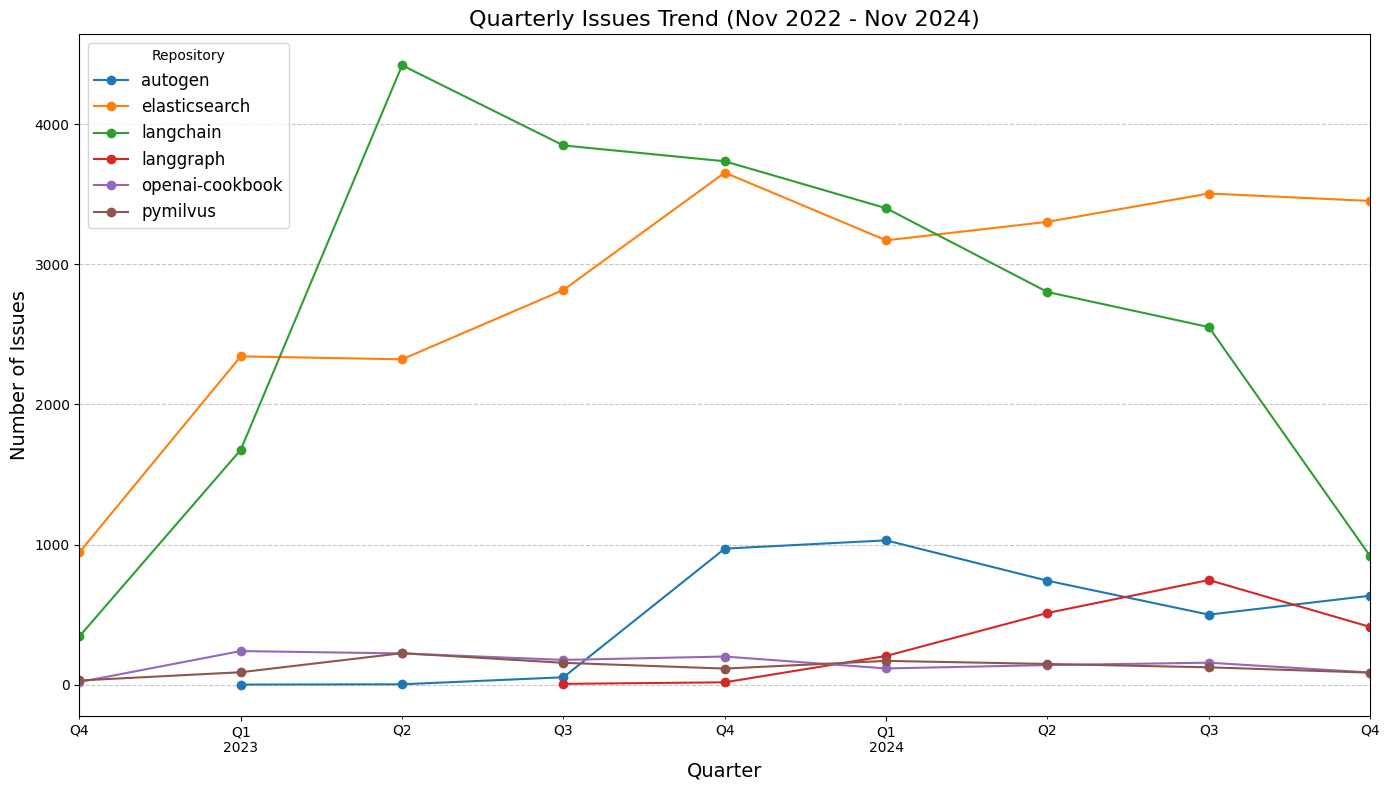

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter only issue data
df_issues = df_detailed[df_detailed["type"] == "issue"]

# Convert created_at column to datetime
df_issues["created_at"] = pd.to_datetime(df_issues["created_at"])

# Filter data from 2022-11-01 to 2024-11-30
start_date = "2022-11-01"
end_date = "2024-11-30"
df_issues = df_issues[(df_issues["created_at"] >= start_date) & (df_issues["created_at"] <= end_date)]

# Set created_at as index for easier resampling
df_issues.set_index("created_at", inplace=True)

# Resample data quarterly for each repository
quarterly_issues = (
    df_issues.groupby("repository")
    .resample("Q")  # Group by quarter
    .size()
    .reset_index(name="issue_count")  # Rename column for counts
)

# Create a pivot table for better plotting
pivot_data = quarterly_issues.pivot(index="created_at", columns="repository", values="issue_count")

# Plot the line chart
plt.figure(figsize=(12, 8))
pivot_data.plot(kind="line", marker="o", figsize=(14, 8))

plt.title("Quarterly Issues Trend (Nov 2022 - Nov 2024)", fontsize=16)
plt.xlabel("Quarter", fontsize=14)
plt.ylabel("Number of Issues", fontsize=14)
plt.legend(title="Repository", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save or show the plot
plt.savefig("quarterly_issues_trend_filtered.png")
plt.show()


<hr style="border:1px solid black"> </hr>

<div class="alert alert-info">   
    
## REQUIREMENT 3
- A bar chart to plot the issues created for every month for every repository
    
</div>

C:\Users\soham\AppData\Local\Temp\ipykernel_18460\2105572857.py:7: DtypeWarning: Columns (5,6,7,8,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_detailed = pd.read_csv("github_all_data.csv")
C:\Users\soham\AppData\Local\Temp\ipykernel_18460\2105572857.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_issues["created_at"] = pd.to_datetime(df_issues["created_at"])
C:\Users\soham\AppData\Local\Temp\ipykernel_18460\2105572857.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")  # Group by month


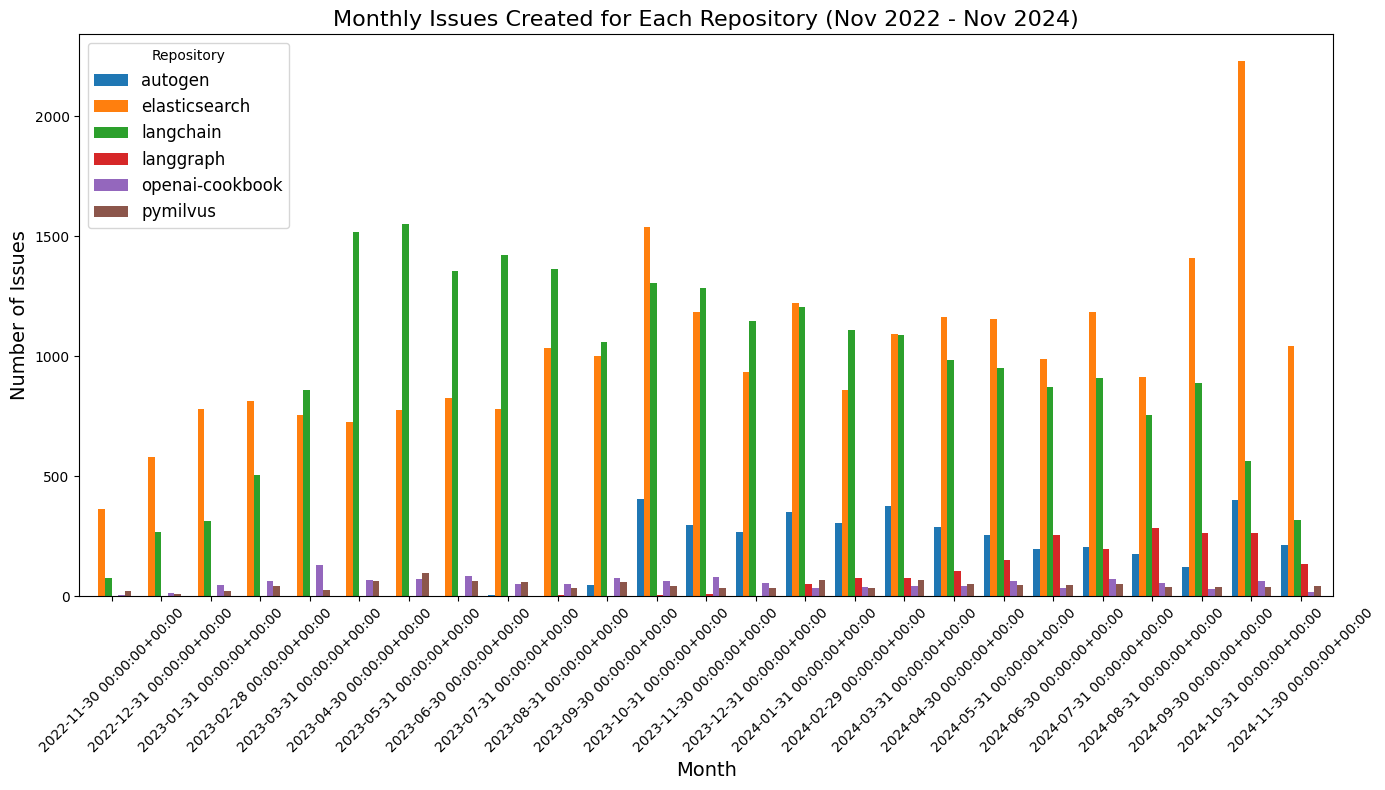

In [2]:
#Add your code for requirement 3 in this cell

import pandas as pd
import matplotlib.pyplot as plt

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter only issue data
df_issues = df_detailed[df_detailed["type"] == "issue"]

# Convert created_at column to datetime
df_issues["created_at"] = pd.to_datetime(df_issues["created_at"])

# Filter data from 2022-11-01 to 2024-11-20
start_date = "2022-11-01"
end_date = "2024-11-20"
df_issues = df_issues[(df_issues["created_at"] >= start_date) & (df_issues["created_at"] <= end_date)]

# Set created_at as index for easier resampling
df_issues.set_index("created_at", inplace=True)

# Resample data monthly for each repository
monthly_issues = (
    df_issues.groupby("repository")
    .resample("M")  # Group by month
    .size()
    .reset_index(name="issue_count")  # Rename column for counts
)

# Create a pivot table for better plotting
pivot_data = monthly_issues.pivot(index="created_at", columns="repository", values="issue_count")

# Plot the bar chart
pivot_data.plot(kind="bar", figsize=(14, 8), width=0.8)

plt.title("Monthly Issues Created for Each Repository (Nov 2022 - Nov 2024)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Issues", fontsize=14)
plt.legend(title="Repository", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Save or show the plot
plt.savefig("monthly_issues_bar_chart.png")
plt.show()


<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 4
- A bar chart to plot the starts for every repository
    
</div>

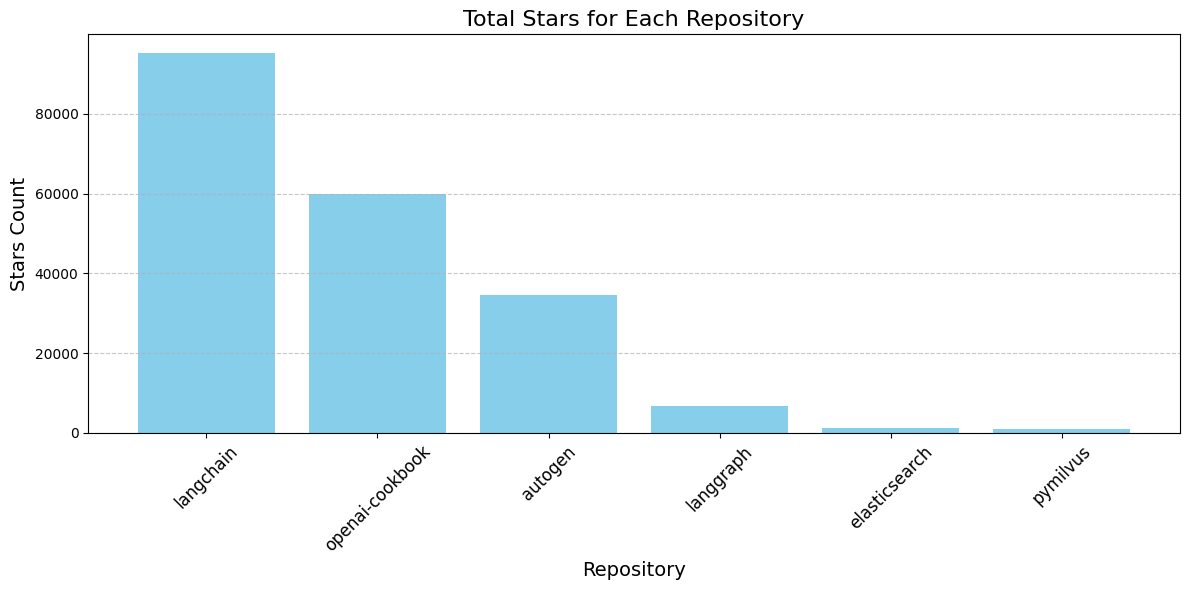

In [3]:
#Add your code for requirement 4 in this cell

import pandas as pd
import matplotlib.pyplot as plt

# Load the summary data
df_summary = pd.read_csv("github_only_summary_data.csv")

# Extract repository names and star counts
repo_stars = df_summary[["repository", "stars"]]

# Sort repositories by star count for better visualization
repo_stars = repo_stars.sort_values(by="stars", ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(repo_stars["repository"], repo_stars["stars"], color="skyblue")

# Add titles and labels
plt.title("Total Stars for Each Repository", fontsize=16)
plt.xlabel("Repository", fontsize=14)
plt.ylabel("Stars Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save or show the plot
plt.savefig("repository_stars_bar_chart.png")
plt.tight_layout()
plt.show()


<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 5
- A bar chart to plot the forks for every repository
    
</div>

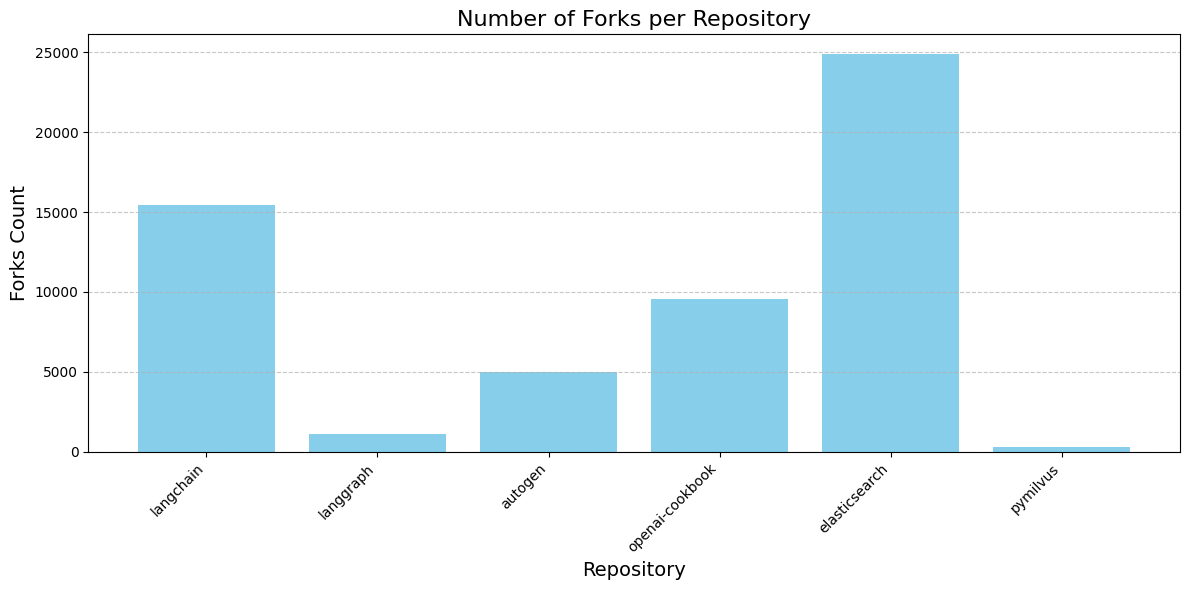

In [4]:
#Add your code for requirement 5 in this cell

import pandas as pd
import matplotlib.pyplot as plt

# Load the summary data that contains the forks count
df_summary = pd.read_csv("github_only_summary_data.csv")

# Plotting a bar chart for the forks count
plt.figure(figsize=(12, 6))
plt.bar(df_summary['repository'], df_summary['forks'], color='skyblue')

# Add titles and labels
plt.title("Number of Forks per Repository", fontsize=16)
plt.xlabel("Repository", fontsize=14)
plt.ylabel("Forks Count", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save or show the plot
plt.tight_layout()
plt.savefig("forks_per_repository_bar_chart.png")
plt.show()



<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 6
- A bar chart to plot the issues closed for every week for every repository
    
</div>

C:\Users\soham\AppData\Local\Temp\ipykernel_18460\783876463.py:9: DtypeWarning: Columns (5,6,7,8,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_detailed = pd.read_csv("github_all_data.csv")
C:\Users\soham\AppData\Local\Temp\ipykernel_18460\783876463.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_issues["closed_at"] = pd.to_datetime(df_issues["closed_at"], errors="coerce")
C:\Users\soham\AppData\Local\Temp\ipykernel_18460\783876463.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_issues["week"] = df_issues["closed_at"].dt.to_period("W").apply(lambda r: r.start_time)


<Figure size 1400x800 with 0 Axes>

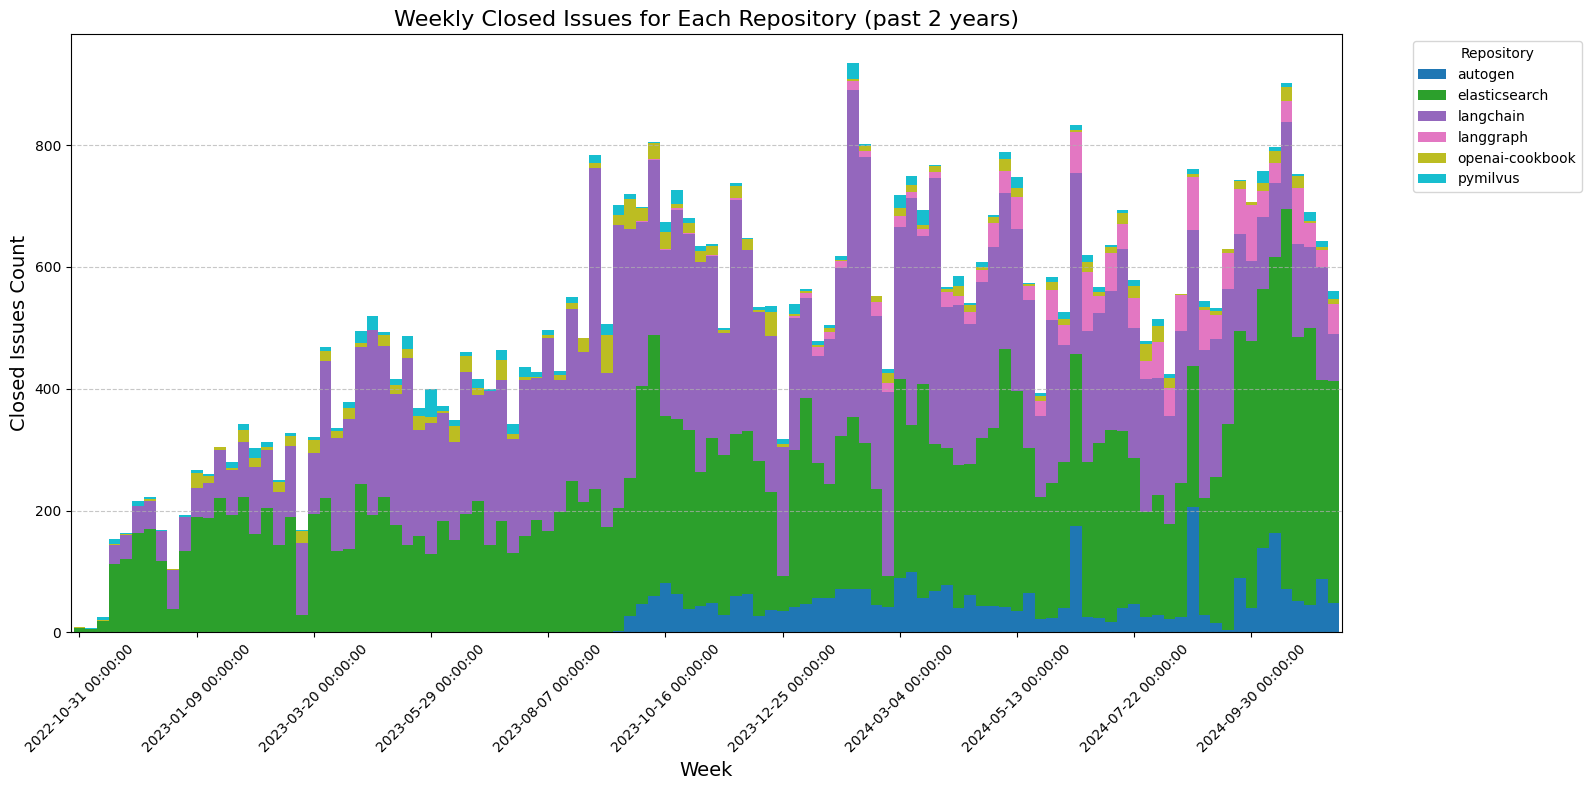

In [5]:
#Add your code for requirement 6 in this cell


import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter data for issues only and within the specified date range
df_issues = df_detailed[df_detailed["type"] == "issue"]
df_issues["closed_at"] = pd.to_datetime(df_issues["closed_at"], errors="coerce")
df_issues = df_issues[(df_issues["closed_at"] >= "2022-11-01") & (df_issues["closed_at"] <= "2024-11-30")]

# Add a week number for grouping
df_issues["week"] = df_issues["closed_at"].dt.to_period("W").apply(lambda r: r.start_time)

# Group by repository and week, then count issues closed
weekly_closed_issues = df_issues.groupby(["repository", "week"]).size().reset_index(name="closed_issues")

# Pivot the data for plotting
weekly_pivot = weekly_closed_issues.pivot(index="week", columns="repository", values="closed_issues").fillna(0)

# Plot the bar chart
plt.figure(figsize=(14, 8))
weekly_pivot.plot(kind="bar", stacked=True, figsize=(16, 8), width=1.0, colormap="tab10")

# Add titles and labels
plt.title("Weekly Closed Issues for Each Repository (past 2 years)", fontsize=16)
plt.xlabel("Week", fontsize=14)
plt.ylabel("Closed Issues Count", fontsize=14)
plt.legend(title="Repository", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(ticks=range(0, len(weekly_pivot), 10), labels=weekly_pivot.index[::10], rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save or show the plot
plt.tight_layout()
plt.savefig("weekly_closed_issues_bar_chart.png")
plt.show()


<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 7
- A stack-bar Chart to plot the created and closed issues for every repository
    
</div>

C:\Users\soham\AppData\Local\Temp\ipykernel_18460\2469595251.py:7: DtypeWarning: Columns (5,6,7,8,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_detailed = pd.read_csv("github_all_data.csv")
C:\Users\soham\AppData\Local\Temp\ipykernel_18460\2469595251.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_issues["created_at"] = pd.to_datetime(df_issues["created_at"], errors="coerce")
C:\Users\soham\AppData\Local\Temp\ipykernel_18460\2469595251.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

<Figure size 1200x600 with 0 Axes>

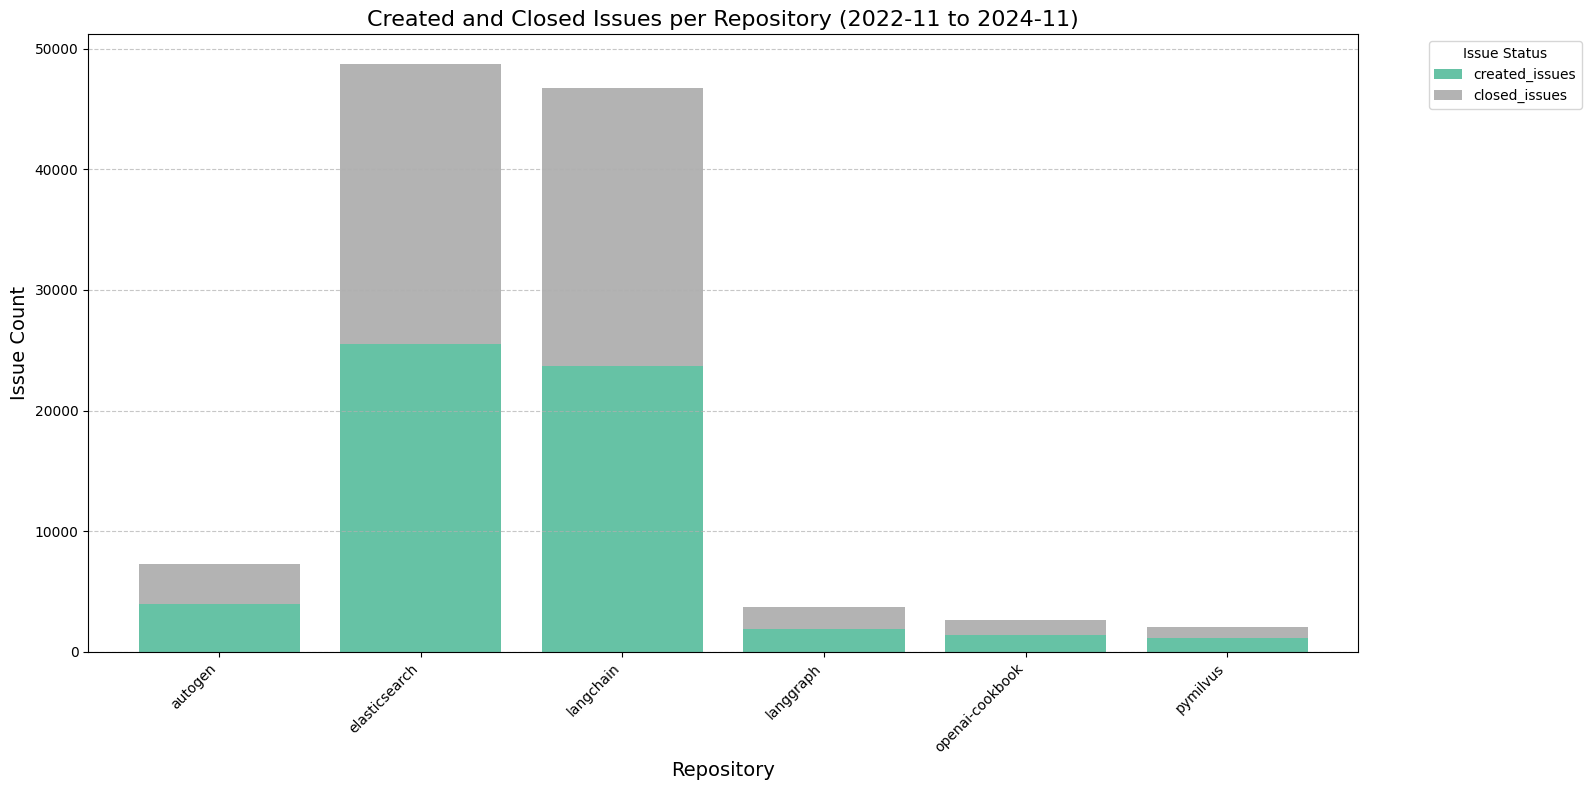

In [6]:
#Add your code for requirement 7 in this cell

import pandas as pd
import matplotlib.pyplot as plt

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter data for issues only
df_issues = df_detailed[df_detailed["type"] == "issue"]

# Convert to datetime and filter data to the specified range (if needed)
df_issues["created_at"] = pd.to_datetime(df_issues["created_at"], errors="coerce")
df_issues["closed_at"] = pd.to_datetime(df_issues["closed_at"], errors="coerce")

# Filter for issues created and closed between November 2022 to November 2024
df_issues = df_issues[(df_issues["created_at"] >= "2022-11-01") & (df_issues["created_at"] <= "2024-11-30")]

# Count created issues per repo
created_issues = df_issues.groupby("repository")["created_at"].count().reset_index(name="created_issues")

# Count closed issues per repo (where closed_at is not null)
closed_issues = df_issues[df_issues["closed_at"].notnull()].groupby("repository")["closed_at"].count().reset_index(name="closed_issues")

# Merge created and closed issues into one dataframe
issues_summary = pd.merge(created_issues, closed_issues, on="repository", how="left").fillna(0)

# Plot the stacked bar chart
plt.figure(figsize=(12, 6))
issues_summary.set_index("repository")[["created_issues", "closed_issues"]].plot(kind="bar", stacked=True, figsize=(16, 8), width=0.8, colormap="Set2")

# Add titles and labels
plt.title("Created and Closed Issues per Repository (2022-11 to 2024-11)", fontsize=16)
plt.xlabel("Repository", fontsize=14)
plt.ylabel("Issue Count", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.legend(title="Issue Status", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save or show the plot
plt.tight_layout()
plt.savefig("created_vs_closed_issues_stack_bar_chart.png")
plt.show()


<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 8 (TENSORFLOW/KERAS LSTM)
- Use TensorFlow/Keras LSTM package to forecast the following for every repository  
</div>

<div class="alert alert-block alert-success">   
    
#### REQ8-1). The day of the week maximum number of issues created 
    
</div>

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 1.9390 - val_accuracy: 0.0000e+00 - val_loss: 1.9414
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.0000e+00 - loss: 1.9198 - val_accuracy: 0.0000e+00 - val_loss: 1.9364
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.0000e+00 - loss: 1.9006 - val_accuracy: 0.0000e+00 - val_loss: 1.9314
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0000e+00 - loss: 1.8814 - val_accuracy: 0.0000e+00 - val_loss: 1.9264
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2500 - loss: 1.8621 - val_accuracy: 0.0000e+00 - val_loss: 1.9214
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5000 - loss: 1.8427 - val_accuracy: 0.0000e+00 - val_loss: 1.9164
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5000 - loss: 1.8230 - val_accuracy: 0.0000e+00 - val_loss: 1.9113
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5000 - loss: 1.8031 

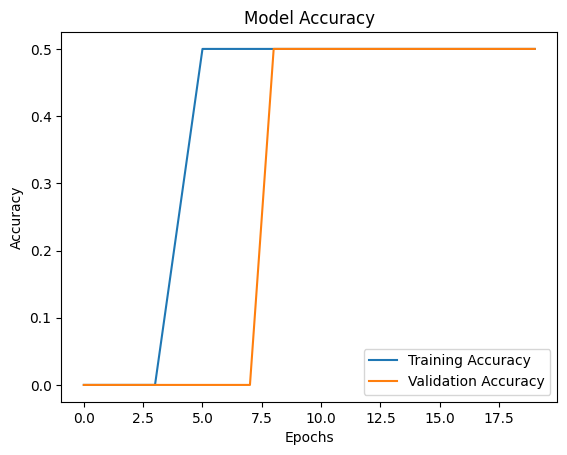

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5000 - loss: 1.8271
Test Accuracy: 50.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
        repository predicted_day_of_week
0          autogen               Tuesday
1    elasticsearch               Tuesday
2        langchain               Tuesday
3        langgraph               Tuesday
4  openai-cookbook               Tuesday
5         pymilvus               Tuesday


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'issues' type
df_issues = df_detailed[df_detailed['type'] == 'issue']

# Convert 'created_at' to datetime
df_issues['created_at'] = pd.to_datetime(df_issues['created_at'])

# Extract the day of the week from 'created_at' (0=Monday, 6=Sunday)
df_issues['day_of_week'] = df_issues['created_at'].dt.dayofweek

# Group by repository and day of the week to count issues created
df_day_of_week = df_issues.groupby(['repository', 'day_of_week']).size().reset_index(name='issue_count')

# Get the average number of issues created for each day of the week across the entire period for each repo
df_avg_day_of_week = df_day_of_week.groupby(['repository', 'day_of_week'])['issue_count'].mean().reset_index()

# Pivot the data to have a row for each repository and columns for days of the week (0-6)
df_pivot = df_avg_day_of_week.pivot(index='repository', columns='day_of_week', values='issue_count')

# Fill missing values with 0 (if any)
df_pivot = df_pivot.fillna(0)

# Check the data
#print(df_pivot.head())

# Prepare the time series data for LSTM
X = df_pivot.values  # Each repo's issue count per day of the week (0-6)
y = np.argmax(X, axis=1)  # Forecast the day with the maximum issues (index of max value)

# Reshape the input for LSTM [samples, time steps, features]
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(X_reshaped) * 0.8)
X_train, X_test = X_reshaped[:train_size], X_reshaped[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Normalize the data (optional but recommended for LSTM)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[1])).reshape(X_test.shape)

# Build the LSTM model
model = Sequential()

# LSTM layer
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Output layer (predicting the day of the week with max issues)
model.add(Dense(units=7, activation='softmax'))  # 7 possible days (0-6)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("forecasting/Tensorflow_LSTM/lstm_day_max_issues_created.png")
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions for each repository in the dataset
y_pred = model.predict(X_reshaped)

# Convert predictions from one-hot encoding to day of the week (0-6)
predicted_days = np.argmax(y_pred, axis=1)

# Create a DataFrame to show predictions for all repositories
predictions_df_all_repos = pd.DataFrame({
    'repository': df_pivot.index,  # All repositories
    'predicted_day_of_week': predicted_days,
})

# Map the predicted day number to the name of the day
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
predictions_df_all_repos['predicted_day_of_week'] = predictions_df_all_repos['predicted_day_of_week'].map(day_mapping)

# Display the predictions for all repositories
print(predictions_df_all_repos)



<div class="alert alert-block alert-success">   
    
#### REQ8-2). The day of the week maximum number of issues closed 

</div>

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 1.9454 - val_accuracy: 0.0000e+00 - val_loss: 1.9428
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.0000e+00 - loss: 1.9265 - val_accuracy: 0.5000 - val_loss: 1.9385
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0000e+00 - loss: 1.9076 - val_accuracy: 0.5000 - val_loss: 1.9341
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2500 - loss: 1.8886 - val_accuracy: 0.5000 - val_loss: 1.9295
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2500 - loss: 1.8694 - val_accuracy: 0.5000 - val_loss: 1.9248
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7500 - loss: 1.8501 - val_accuracy: 0.5000 - val_loss: 1.9198
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7500 - loss: 1.8304 - val_accuracy: 0.5000 - val_loss: 1.9147
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7500 - loss: 1.8103 - val_accuracy: 0.5000 - val

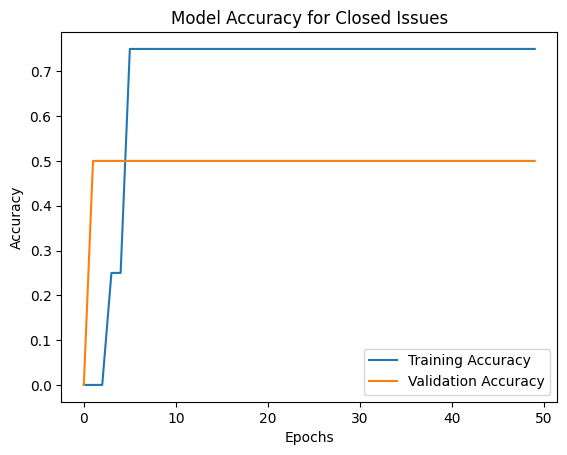

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5000 - loss: 1.1837
Test Accuracy for Closed Issues: 50.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
        repository predicted_day_of_week
0          autogen               Tuesday
1    elasticsearch               Tuesday
2        langchain               Tuesday
3        langgraph               Tuesday
4  openai-cookbook               Tuesday
5         pymilvus               Tuesday


In [3]:
#Add your code for requirement 8.2 in this cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'issue' type and 'closed' status
df_closed_issues = df_detailed[(df_detailed['type'] == 'issue') & (df_detailed['state'] == 'closed')]

# Convert 'created_at' to datetime
df_closed_issues['created_at'] = pd.to_datetime(df_closed_issues['created_at'])

# Extract the day of the week from 'created_at' (0=Monday, 6=Sunday)
df_closed_issues['day_of_week'] = df_closed_issues['created_at'].dt.dayofweek

# Group by repository and day of the week to count closed issues
df_day_of_week_closed = df_closed_issues.groupby(['repository', 'day_of_week']).size().reset_index(name='closed_issue_count')

# Get the average number of closed issues for each day of the week across the entire period for each repo
df_avg_day_of_week_closed = df_day_of_week_closed.groupby(['repository', 'day_of_week'])['closed_issue_count'].mean().reset_index()

# Pivot the data to have a row for each repository and columns for days of the week (0-6)
df_pivot_closed = df_avg_day_of_week_closed.pivot(index='repository', columns='day_of_week', values='closed_issue_count')

# Fill missing values with 0 (if any)
df_pivot_closed = df_pivot_closed.fillna(0)

# Check the data
#print(df_pivot_closed.head())

# Prepare the time series data for LSTM
X_closed = df_pivot_closed.values  # Each repo's closed issue count per day of the week (0-6)
y_closed = np.argmax(X_closed, axis=1)  # Forecast the day with the maximum closed issues (index of max value)

# Reshape the input for LSTM [samples, time steps, features]
X_reshaped_closed = X_closed.reshape((X_closed.shape[0], X_closed.shape[1], 1))

# Split data into training and testing sets (80% train, 20% test)
train_size_closed = int(len(X_reshaped_closed) * 0.8)
X_train_closed, X_test_closed = X_reshaped_closed[:train_size_closed], X_reshaped_closed[train_size_closed:]
y_train_closed, y_test_closed = y_closed[:train_size_closed], y_closed[train_size_closed:]

# Normalize the data (optional but recommended for LSTM)
scaler_closed = MinMaxScaler()
X_train_closed = scaler_closed.fit_transform(X_train_closed.reshape(-1, X_train_closed.shape[1])).reshape(X_train_closed.shape)
X_test_closed = scaler_closed.transform(X_test_closed.reshape(-1, X_test_closed.shape[1])).reshape(X_test_closed.shape)

# Build the LSTM model
model_closed = Sequential()

# LSTM layer
model_closed.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_closed.shape[1], X_train_closed.shape[2])))

# Output layer (predicting the day of the week with max closed issues)
model_closed.add(Dense(units=7, activation='softmax'))  # 7 possible days (0-6)

# Compile the model
model_closed.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_closed = model_closed.fit(X_train_closed, y_train_closed, epochs=50, batch_size=16, validation_data=(X_test_closed, y_test_closed), verbose=1)

# Plot training history
plt.plot(history_closed.history['accuracy'], label='Training Accuracy')
plt.plot(history_closed.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy for Closed Issues')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("forecasting/Tensorflow_LSTM/lstm_day_max_issues_closed.png")
plt.show()

# Evaluate the model on the test set
test_loss_closed, test_accuracy_closed = model_closed.evaluate(X_test_closed, y_test_closed)
print(f"Test Accuracy for Closed Issues: {test_accuracy_closed * 100:.2f}%")

# Make predictions for each repository in the dataset
y_pred_closed = model_closed.predict(X_reshaped_closed)

# Convert predictions from one-hot encoding to day of the week (0-6)
predicted_days_closed = np.argmax(y_pred_closed, axis=1)

# Create a DataFrame to show predictions for all repositories
predictions_df_all_repos_closed = pd.DataFrame({
    'repository': df_pivot_closed.index,  # All repositories
    'predicted_day_of_week': predicted_days_closed,
})

# Map the predicted day number to the name of the day
predictions_df_all_repos_closed['predicted_day_of_week'] = predictions_df_all_repos_closed['predicted_day_of_week'].map(day_mapping)

# Display the predictions for all repositories
print(predictions_df_all_repos_closed)




<div class="alert alert-block alert-success">   
    
#### REQ8-3). The month of the year that has maximum number of issues closed 


</div>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'issue' type and 'closed' status
df_closed_issues = df_detailed[(df_detailed['type'] == 'issue') & (df_detailed['state'] == 'closed')]

# Convert 'created_at' to datetime
df_closed_issues['created_at'] = pd.to_datetime(df_closed_issues['created_at'])

# Extract the month of the year (1=January, 12=December)
df_closed_issues['month_of_year'] = df_closed_issues['created_at'].dt.month

# Group by repository and month of the year to count closed issues
df_month_of_year_closed = df_closed_issues.groupby(['repository', 'month_of_year']).size().reset_index(name='closed_issue_count')

# Get the average number of closed issues for each month of the year across the entire period for each repo
df_avg_month_of_year_closed = df_month_of_year_closed.groupby(['repository', 'month_of_year'])['closed_issue_count'].mean().reset_index()

# Pivot the data to have a row for each repository and columns for months of the year (1-12)
df_pivot_closed = df_avg_month_of_year_closed.pivot(index='repository', columns='month_of_year', values='closed_issue_count')

# Fill missing values with 0 (if any)
df_pivot_closed = df_pivot_closed.fillna(0)

# Check the data
#print(df_pivot_closed.head())

# Prepare the time series data for LSTM
X_closed_month = df_pivot_closed.values  # Each repo's closed issue count per month (1-12)
y_closed_month = np.argmax(X_closed_month, axis=1)  # Forecast the month with the maximum closed issues (index of max value)

# Reshape the input for LSTM [samples, time steps, features]
X_reshaped_month = X_closed_month.reshape((X_closed_month.shape[0], X_closed_month.shape[1], 1))

# Split data into training and testing sets (80% train, 20% test)
train_size_month = int(len(X_reshaped_month) * 0.8)
X_train_month, X_test_month = X_reshaped_month[:train_size_month], X_reshaped_month[train_size_month:]
y_train_month, y_test_month = y_closed_month[:train_size_month], y_closed_month[train_size_month:]

# Normalize the data (optional but recommended for LSTM)
scaler_month = MinMaxScaler()
X_train_month = scaler_month.fit_transform(X_train_month.reshape(-1, X_train_month.shape[1])).reshape(X_train_month.shape)
X_test_month = scaler_month.transform(X_test_month.reshape(-1, X_test_month.shape[1])).reshape(X_test_month.shape)

# Build the LSTM model
model_month = Sequential()

# LSTM layer
model_month.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_month.shape[1], X_train_month.shape[2])))

# Output layer (predicting the month of the year with max closed issues)
model_month.add(Dense(units=12, activation='softmax'))  # 12 possible months (1-12)

# Compile the model
model_month.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_month = model_month.fit(X_train_month, y_train_month, epochs=50, batch_size=16, validation_data=(X_test_month, y_test_month), verbose=1)

# Evaluate the model on the test set
test_loss_month, test_accuracy_month = model_month.evaluate(X_test_month, y_test_month)
#print(f"Test Accuracy for Closed Issues by Month: {test_accuracy_month * 100:.2f}%")

# Make predictions for each repository in the dataset
y_pred_month = model_month.predict(X_reshaped_month)

# Convert predictions from one-hot encoding to month of the year (1-12)
predicted_months = np.argmax(y_pred_month, axis=1) + 1  # +1 to map to months (1-12)

# Create a DataFrame to show predictions for all repositories
predictions_df_all_repos_month = pd.DataFrame({
    'repository': df_pivot_closed.index,  # All repositories
    'predicted_month_of_year': predicted_months,
})

# Map the predicted month number to the name of the month
month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 
                 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
predictions_df_all_repos_month['predicted_month_of_year'] = predictions_df_all_repos_month['predicted_month_of_year'].map(month_mapping)

# Display the predictions for all repositories
print(predictions_df_all_repos_month)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 2.4563 - val_accuracy: 0.0000e+00 - val_loss: 2.4864
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2500 - loss: 2.4395 - val_accuracy: 0.0000e+00 - val_loss: 2.4879
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5000 - loss: 2.4228 - val_accuracy: 0.0000e+00 - val_loss: 2.4894
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5000 - loss: 2.4061 - val_accuracy: 0.0000e+00 - val_loss: 2.4908
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5000 - loss: 2.3892 - val_accuracy: 0.0000e+00 - val_loss: 2.4922
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5000 - loss: 2.3722 - val_accuracy: 0.0000e+00 - val_loss: 2.4937
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5000 - loss: 2.3549 - val_accuracy: 0.0000e+00 - val_loss: 2.4952
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5000 - loss: 2.3371 - val_accura

<div class="alert alert-block alert-success">   
    
#### REQ8-4). Plot the created issues forecast 

</div>

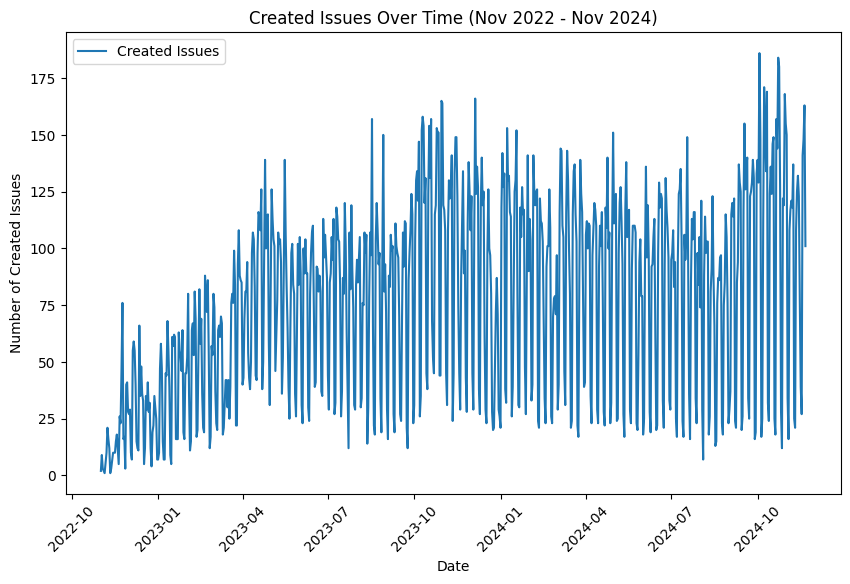

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1625 - val_loss: 0.0830
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0436 - val_loss: 0.0721
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0409 - val_loss: 0.0717
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0400 - val_loss: 0.0700
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0400 - val_loss: 0.0694
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0400 - val_loss: 0.0664
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0409 - val_loss: 0.0646
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0361 - val_loss: 0.0653
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0325 - val_loss: 0.0669
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0323 - val_loss: 0.0342
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0236 - val_loss: 0.0311
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0194

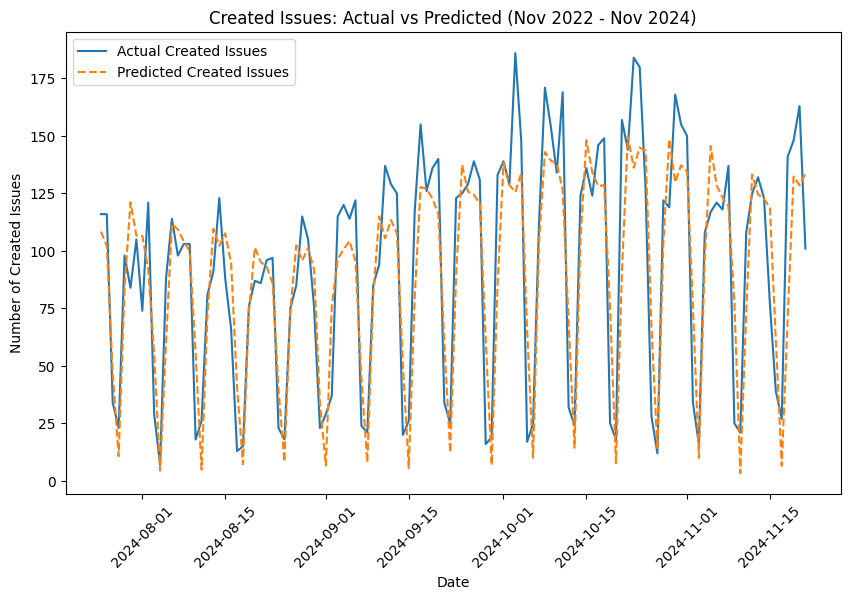

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'issue' type and 'created' status
df_created_issues = df_detailed[df_detailed['type'] == 'issue']

# Convert 'created_at' to datetime
df_created_issues['created_at'] = pd.to_datetime(df_created_issues['created_at'])

# Filter data between November 2022 and November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_created_issues = df_created_issues[(df_created_issues['created_at'] >= start_date) & (df_created_issues['created_at'] <= end_date)]

# Extract the date part (ignoring time) and group by date to count created issues
df_created_issues['date'] = df_created_issues['created_at'].dt.date
df_created_daily = df_created_issues.groupby('date').size().reset_index(name='created_issue_count')

# Plot the original created issues over time (for visualization)
plt.figure(figsize=(10, 6))
plt.plot(df_created_daily['date'], df_created_daily['created_issue_count'], label='Created Issues')
plt.xlabel('Date')
plt.ylabel('Number of Created Issues')
plt.title('Created Issues Over Time (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Prepare the time series data for LSTM
created_issues_values = df_created_daily['created_issue_count'].values.reshape(-1, 1)

# Normalize the data (MinMaxScaler)
scaler_created_issues = MinMaxScaler(feature_range=(0, 1))
created_issues_scaled = scaler_created_issues.fit_transform(created_issues_values)

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(created_issues_scaled) * 0.8)
train_data, test_data = created_issues_scaled[:train_size], created_issues_scaled[train_size:]

# Prepare the data for LSTM (creating X and y data)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Reshape data into the form that can be used by LSTM (samples, time steps, features)
time_step = 30  # Use the past 30 days to predict the next day's created issues
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model_created_issues = Sequential()
model_created_issues.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_created_issues.add(Dense(units=1))

# Compile the model
model_created_issues.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_created_issues.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict the created issues on the test set
predicted_created_issues = model_created_issues.predict(X_test)

# Inverse transform the predicted values to get them back to original scale
predicted_created_issues = scaler_created_issues.inverse_transform(predicted_created_issues)

# Inverse transform the actual values to get them back to original scale
y_test_actual = scaler_created_issues.inverse_transform(y_test.reshape(-1, 1))

# Plot the original vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_created_daily['date'][-len(y_test_actual):], y_test_actual, label='Actual Created Issues')
plt.plot(df_created_daily['date'][-len(predicted_created_issues):], predicted_created_issues, label='Predicted Created Issues', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Created Issues')
plt.title('Created Issues: Actual vs Predicted (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig("forecasting/Tensorflow_LSTM/issues_created_over_time.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-5). Plot the closed issues forecast 

</div>

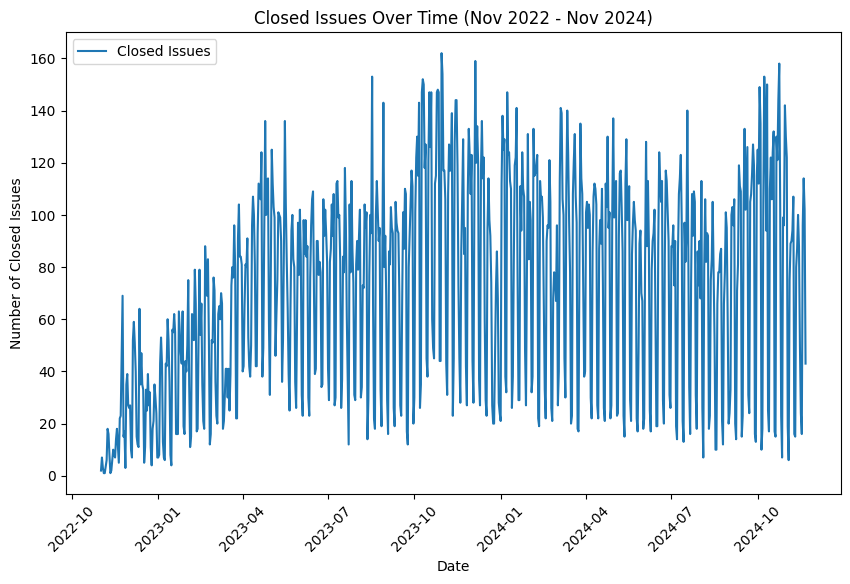

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0981 - val_loss: 0.0733
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0552 - val_loss: 0.0778
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0522 - val_loss: 0.0727
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0510 - val_loss: 0.0711
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0484 - val_loss: 0.0698
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0478 - val_loss: 0.0682
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0446 - val_loss: 0.0651
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0446 - val_loss: 0.0624
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0439 - val_loss: 0.0535
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0347 - val_loss: 0.0372
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0252 - val_loss: 0.0388
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0273

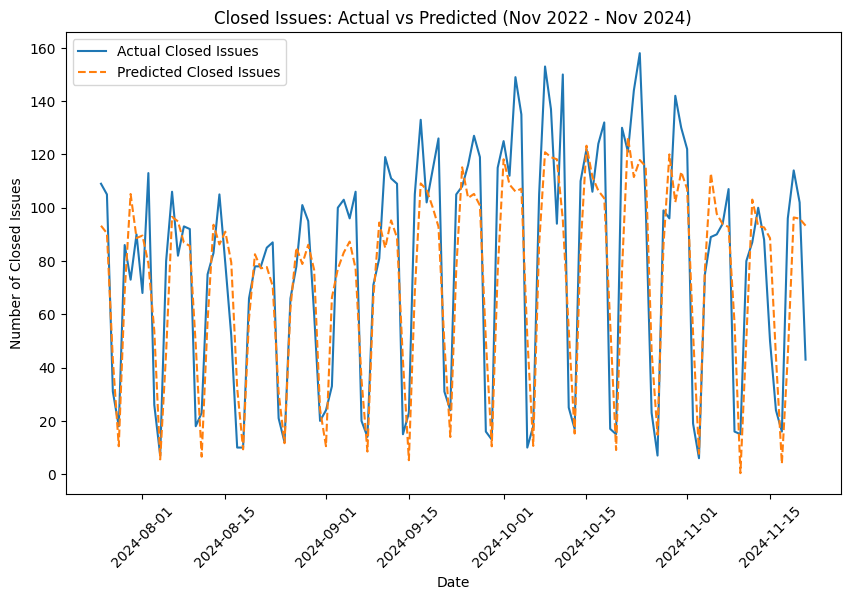

In [5]:
#Add your code for requirement 8.5 in this cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'issue' type and 'closed' status
df_closed_issues = df_detailed[df_detailed['type'] == 'issue']
df_closed_issues = df_closed_issues[df_closed_issues['state'] == 'closed']

# Convert 'created_at' to datetime
df_closed_issues['created_at'] = pd.to_datetime(df_closed_issues['created_at'])

# Filter data between November 2022 and November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_closed_issues = df_closed_issues[(df_closed_issues['created_at'] >= start_date) & (df_closed_issues['created_at'] <= end_date)]

# Extract the date part (ignoring time) and group by date to count closed issues
df_closed_issues['date'] = df_closed_issues['created_at'].dt.date
df_closed_daily = df_closed_issues.groupby('date').size().reset_index(name='closed_issue_count')

# Plot the original closed issues over time (for visualization)
plt.figure(figsize=(10, 6))
plt.plot(df_closed_daily['date'], df_closed_daily['closed_issue_count'], label='Closed Issues')
plt.xlabel('Date')
plt.ylabel('Number of Closed Issues')
plt.title('Closed Issues Over Time (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Prepare the time series data for LSTM
closed_issues_values = df_closed_daily['closed_issue_count'].values.reshape(-1, 1)

# Normalize the data (MinMaxScaler)
scaler_closed_issues = MinMaxScaler(feature_range=(0, 1))
closed_issues_scaled = scaler_closed_issues.fit_transform(closed_issues_values)

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(closed_issues_scaled) * 0.8)
train_data, test_data = closed_issues_scaled[:train_size], closed_issues_scaled[train_size:]

# Prepare the data for LSTM (creating X and y data)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Reshape data into the form that can be used by LSTM (samples, time steps, features)
time_step = 30  # Use the past 30 days to predict the next day's closed issues
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model for closed issues
model_closed_issues = Sequential()
model_closed_issues.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_closed_issues.add(Dense(units=1))

# Compile the model
model_closed_issues.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_closed_issues.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict the closed issues on the test set
predicted_closed_issues = model_closed_issues.predict(X_test)

# Inverse transform the predicted values to get them back to original scale
predicted_closed_issues = scaler_closed_issues.inverse_transform(predicted_closed_issues)

# Inverse transform the actual values to get them back to original scale
y_test_actual = scaler_closed_issues.inverse_transform(y_test.reshape(-1, 1))

# Plot the original vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_closed_daily['date'][-len(y_test_actual):], y_test_actual, label='Actual Closed Issues')
plt.plot(df_closed_daily['date'][-len(predicted_closed_issues):], predicted_closed_issues, label='Predicted Closed Issues', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Closed Issues')
plt.title('Closed Issues: Actual vs Predicted (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig("forecasting/Tensorflow_LSTM/closed_issues_forecast.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-6). Plot the pulls forecast 

</div>

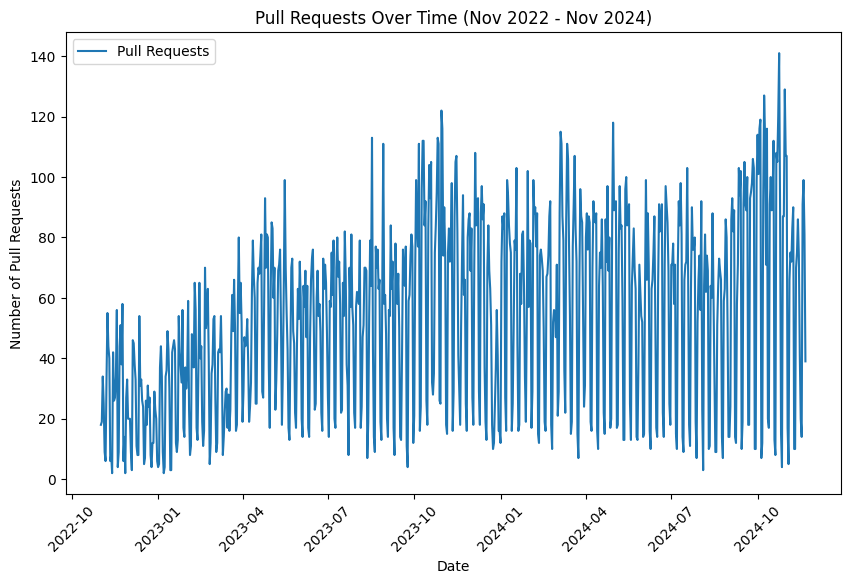

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0857 - val_loss: 0.0725
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0402 - val_loss: 0.0712
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0391 - val_loss: 0.0717
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0411 - val_loss: 0.0692
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0374 - val_loss: 0.0664
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0376 - val_loss: 0.0645
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0330 - val_loss: 0.0672
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0369 - val_loss: 0.0662
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0334 - val_loss: 0.0548
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0296 - val_loss: 0.0477
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0263 - val_loss: 0.0351
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.024

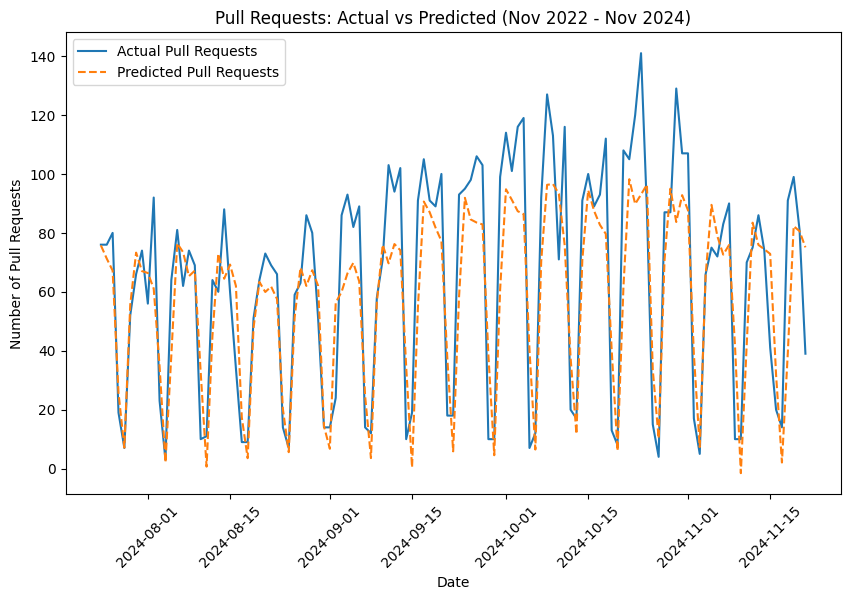

In [6]:
#Add your code for requirement 8.6 in this cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'pull_request' type and 'closed' status (assuming 'closed' pull requests)
df_pulls = df_detailed[df_detailed['type'] == 'pull_request']
df_pulls = df_pulls[df_pulls['state'] == 'closed']

# Convert 'created_at' to datetime
df_pulls['created_at'] = pd.to_datetime(df_pulls['created_at'])

# Filter data between November 2022 and November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_pulls = df_pulls[(df_pulls['created_at'] >= start_date) & (df_pulls['created_at'] <= end_date)]

# Extract the date part (ignoring time) and group by date to count pull requests
df_pulls['date'] = df_pulls['created_at'].dt.date
df_pulls_daily = df_pulls.groupby('date').size().reset_index(name='pull_request_count')

# Plot the original pull requests over time (for visualization)
plt.figure(figsize=(10, 6))
plt.plot(df_pulls_daily['date'], df_pulls_daily['pull_request_count'], label='Pull Requests')
plt.xlabel('Date')
plt.ylabel('Number of Pull Requests')
plt.title('Pull Requests Over Time (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Prepare the time series data for LSTM
pulls_values = df_pulls_daily['pull_request_count'].values.reshape(-1, 1)

# Normalize the data (MinMaxScaler)
scaler_pulls = MinMaxScaler(feature_range=(0, 1))
pulls_scaled = scaler_pulls.fit_transform(pulls_values)

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(pulls_scaled) * 0.8)
train_data, test_data = pulls_scaled[:train_size], pulls_scaled[train_size:]

# Prepare the data for LSTM (creating X and y data)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Reshape data into the form that can be used by LSTM (samples, time steps, features)
time_step = 30  # Use the past 30 days to predict the next day's pull requests
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model for pull requests
model_pulls = Sequential()
model_pulls.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_pulls.add(Dense(units=1))

# Compile the model
model_pulls.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_pulls.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict the pull requests on the test set
predicted_pulls = model_pulls.predict(X_test)

# Inverse transform the predicted values to get them back to original scale
predicted_pulls = scaler_pulls.inverse_transform(predicted_pulls)

# Inverse transform the actual values to get them back to original scale
y_test_actual = scaler_pulls.inverse_transform(y_test.reshape(-1, 1))

# Plot the original vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_pulls_daily['date'][-len(y_test_actual):], y_test_actual, label='Actual Pull Requests')
plt.plot(df_pulls_daily['date'][-len(predicted_pulls):], predicted_pulls, label='Predicted Pull Requests', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Pull Requests')
plt.title('Pull Requests: Actual vs Predicted (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig("forecasting/Tensorflow_LSTM/pull_forecast.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-7). Plot the commits forecast

</div>

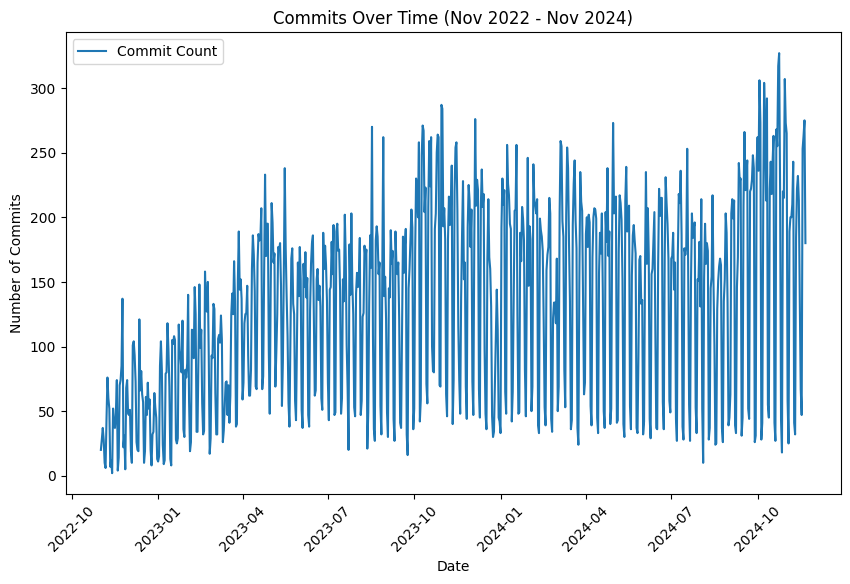

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1036 - val_loss: 0.0745
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0428 - val_loss: 0.0761
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0405 - val_loss: 0.0710
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0437 - val_loss: 0.0721
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0417 - val_loss: 0.0755
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0394 - val_loss: 0.0689
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0386 - val_loss: 0.0664
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0381 - val_loss: 0.0656
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0355 - val_loss: 0.0590
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0310 - val_loss: 0.0359
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0219 - val_loss: 0.0396
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0189

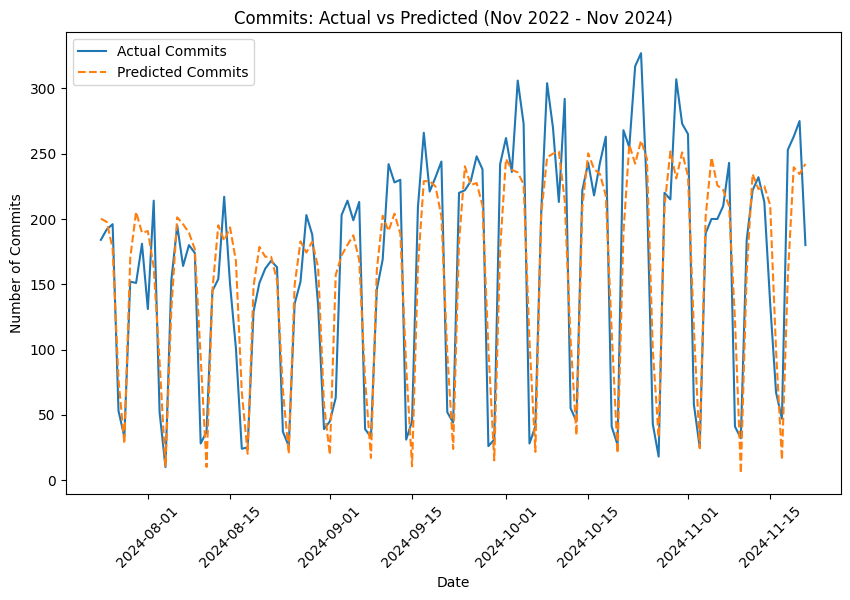

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Load the data
df_commits = pd.read_csv("github_all_data.csv")

# Extract commit date (assuming the 'created_at' column contains commit timestamp)
df_commits['created_at'] = pd.to_datetime(df_commits['created_at'])

# Filter commits from November 2022 to November 2024 (adjust dates if needed)
start_date = '2022-11-01'
end_date = '2024-11-30'
df_commits = df_commits[(df_commits['created_at'] >= start_date) & (df_commits['created_at'] <= end_date)]

# Group by date and count the number of commits per day
df_commits['date'] = df_commits['created_at'].dt.date
df_commits_daily = df_commits.groupby('date').size().reset_index(name='commit_count')

# Plot the commits over time
plt.figure(figsize=(10, 6))
plt.plot(df_commits_daily['date'], df_commits_daily['commit_count'], label='Commit Count')
plt.xlabel('Date')
plt.ylabel('Number of Commits')
plt.title('Commits Over Time (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Prepare the time series data for LSTM
commits_values = df_commits_daily['commit_count'].values.reshape(-1, 1)

# Normalize the data
scaler_commits = MinMaxScaler(feature_range=(0, 1))
commits_scaled = scaler_commits.fit_transform(commits_values)

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(commits_scaled) * 0.8)
train_data, test_data = commits_scaled[:train_size], commits_scaled[train_size:]

# Create the dataset for LSTM (X, y)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Reshape data into the form that can be used by LSTM (samples, time steps, features)
time_step = 30  # Use the past 30 days to predict the next day's commits
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model_commits = Sequential()
model_commits.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_commits.add(Dense(units=1))

# Compile the model
model_commits.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_commits.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict the commits on the test set
predicted_commits = model_commits.predict(X_test)

# Inverse transform the predicted values to get them back to original scale
predicted_commits = scaler_commits.inverse_transform(predicted_commits)

# Inverse transform the actual values to get them back to original scale
y_test_actual = scaler_commits.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs predicted commits
plt.figure(figsize=(10, 6))
plt.plot(df_commits_daily['date'][-len(y_test_actual):], y_test_actual, label='Actual Commits')
plt.plot(df_commits_daily['date'][-len(predicted_commits):], predicted_commits, label='Predicted Commits', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Commits')
plt.title('Commits: Actual vs Predicted (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig("forecasting/Tensorflow_LSTM/commits_forecast.png")
plt.show()



<div class="alert alert-block alert-success">   
    
#### REQ8-8). Plot the branches forecast

</div>

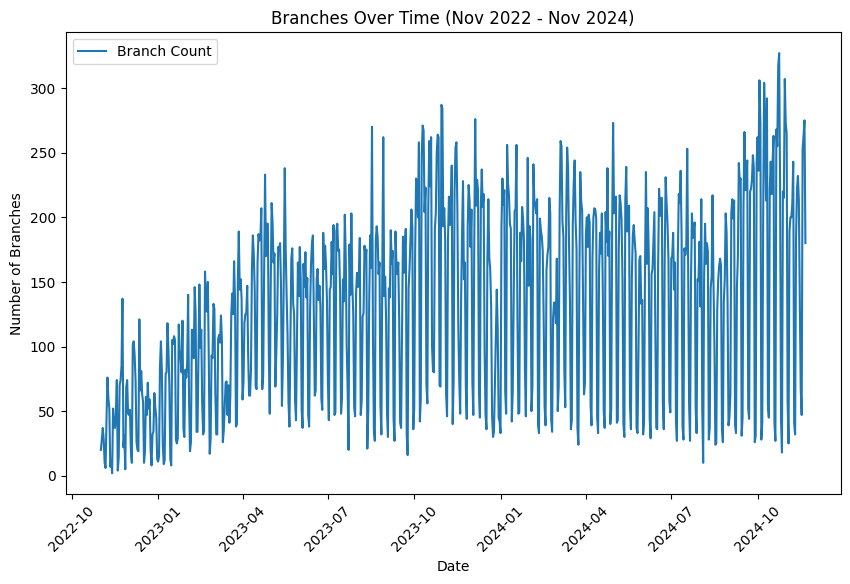

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0911 - val_loss: 0.0769
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0405 - val_loss: 0.0755
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0407 - val_loss: 0.0823
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0395 - val_loss: 0.0727
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0403 - val_loss: 0.0712
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0365 - val_loss: 0.0697
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0377 - val_loss: 0.0630
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0375 - val_loss: 0.0549
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0293 - val_loss: 0.0415
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0216 - val_loss: 0.0362
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0203 - val_loss: 0.0368
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0204

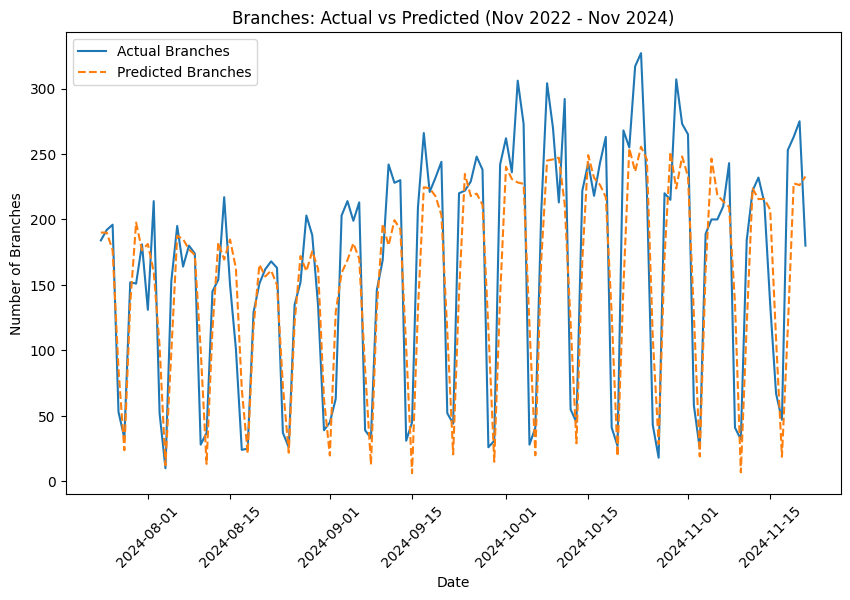

In [8]:
#Add your code for requirement 8.8 in this cell

# Load the data
df_branches = pd.read_csv("github_all_data.csv")

# Assuming there is a 'branch' or 'ref' column to track branch names
# Extract the date (assuming 'created_at' column contains timestamp)
df_branches['created_at'] = pd.to_datetime(df_branches['created_at'])

# Filter data between Nov 2022 and Nov 2024 (adjust as necessary)
df_branches = df_branches[(df_branches['created_at'] >= start_date) & (df_branches['created_at'] <= end_date)]

# Filter for the 'branch' column (assuming it exists)
# Group by date and count the number of branches per day
df_branches_daily = df_branches.groupby(df_branches['created_at'].dt.date).size().reset_index(name='branch_count')

# Plot the branches over time
plt.figure(figsize=(10, 6))
plt.plot(df_branches_daily['created_at'], df_branches_daily['branch_count'], label='Branch Count')
plt.xlabel('Date')
plt.ylabel('Number of Branches')
plt.title('Branches Over Time (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Prepare the time series data for LSTM
branches_values = df_branches_daily['branch_count'].values.reshape(-1, 1)

# Normalize the data
scaler_branches = MinMaxScaler(feature_range=(0, 1))
branches_scaled = scaler_branches.fit_transform(branches_values)

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(branches_scaled) * 0.8)
train_data, test_data = branches_scaled[:train_size], branches_scaled[train_size:]

# Create the dataset for LSTM (X, y)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Reshape data into the form that can be used by LSTM (samples, time steps, features)
time_step = 30  # Use the past 30 days to predict the next day's branches
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model_branches = Sequential()
model_branches.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_branches.add(Dense(units=1))

# Compile the model
model_branches.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_branches.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict the branches on the test set
predicted_branches = model_branches.predict(X_test)

# Inverse transform the predicted values to get them back to original scale
predicted_branches = scaler_branches.inverse_transform(predicted_branches)

# Inverse transform the actual values to get them back to original scale
y_test_actual = scaler_branches.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs predicted branches
plt.figure(figsize=(10, 6))
plt.plot(df_branches_daily['created_at'][-len(y_test_actual):], y_test_actual, label='Actual Branches')
plt.plot(df_branches_daily['created_at'][-len(predicted_branches):], predicted_branches, label='Predicted Branches', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Branches')
plt.title('Branches: Actual vs Predicted (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig("forecasting/Tensorflow_LSTM/branches_forecast.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-9). Plot the contributors forecast

</div>

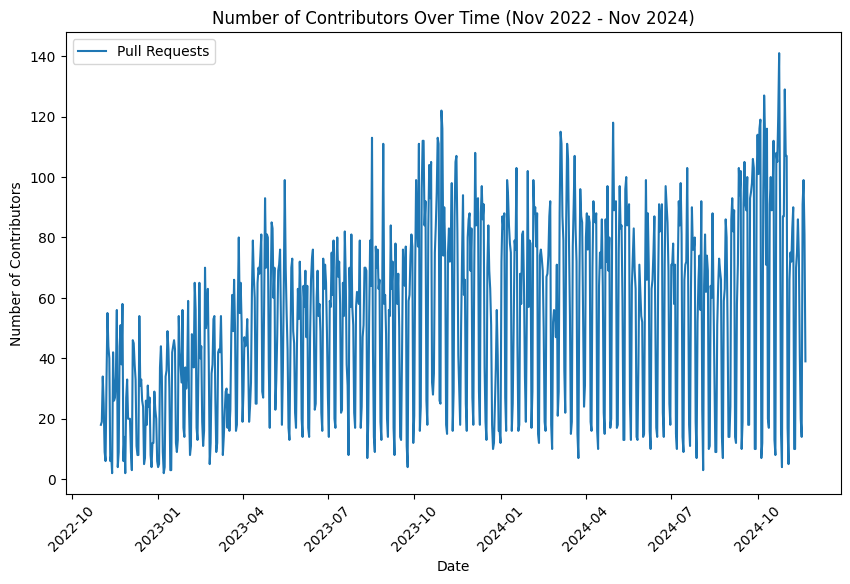

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0925 - val_loss: 0.0724
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0406 - val_loss: 0.0718
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0383 - val_loss: 0.0733
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0388 - val_loss: 0.0710
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0407 - val_loss: 0.0692
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0389 - val_loss: 0.0683
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0387 - val_loss: 0.0738
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0370 - val_loss: 0.0619
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0348 - val_loss: 0.0534
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0347 - val_loss: 0.0416
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0268 - val_loss: 0.0337
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.02

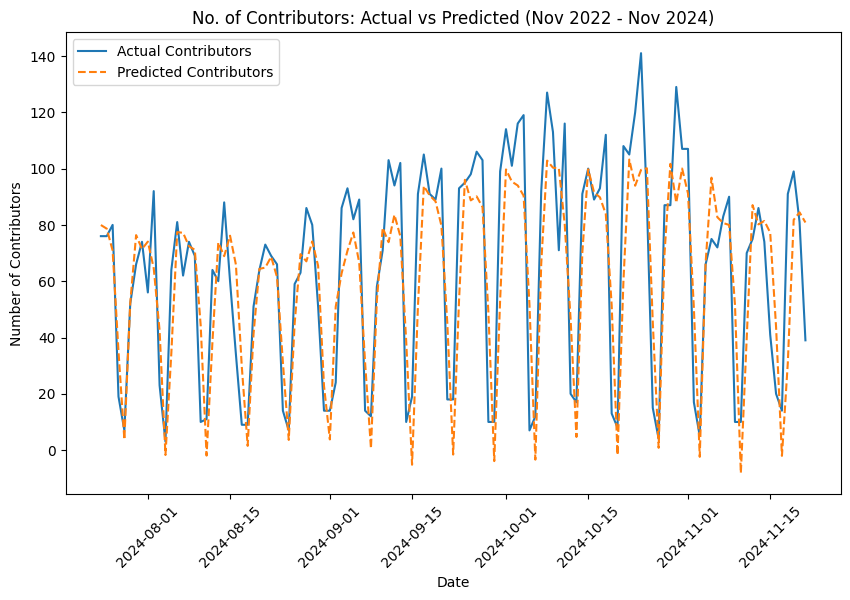

In [9]:
#Add your code for requirement 8.6 in this cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'pull_request' type and 'closed' status (assuming 'closed' pull requests)
df_pulls = df_detailed[df_detailed['type'] == 'pull_request']
df_pulls = df_pulls[df_pulls['state'] == 'closed']

# Convert 'created_at' to datetime
df_pulls['created_at'] = pd.to_datetime(df_pulls['created_at'])

# Filter data between November 2022 and November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_pulls = df_pulls[(df_pulls['created_at'] >= start_date) & (df_pulls['created_at'] <= end_date)]

# Extract the date part (ignoring time) and group by date to count pull requests
df_pulls['date'] = df_pulls['created_at'].dt.date
df_pulls_daily = df_pulls.groupby('date').size().reset_index(name='pull_request_count')

# Plot the original pull requests over time (for visualization)
plt.figure(figsize=(10, 6))
plt.plot(df_pulls_daily['date'], df_pulls_daily['pull_request_count'], label='Pull Requests')
plt.xlabel('Date')
plt.ylabel('Number of Contributors')
plt.title('Number of Contributors Over Time (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Prepare the time series data for LSTM
pulls_values = df_pulls_daily['pull_request_count'].values.reshape(-1, 1)

# Normalize the data (MinMaxScaler)
scaler_pulls = MinMaxScaler(feature_range=(0, 1))
pulls_scaled = scaler_pulls.fit_transform(pulls_values)

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(pulls_scaled) * 0.8)
train_data, test_data = pulls_scaled[:train_size], pulls_scaled[train_size:]

# Prepare the data for LSTM (creating X and y data)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Reshape data into the form that can be used by LSTM (samples, time steps, features)
time_step = 30  # Use the past 30 days to predict the next day's pull requests
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model for pull requests
model_pulls = Sequential()
model_pulls.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_pulls.add(Dense(units=1))

# Compile the model
model_pulls.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_pulls.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict the pull requests on the test set
predicted_pulls = model_pulls.predict(X_test)

# Inverse transform the predicted values to get them back to original scale
predicted_pulls = scaler_pulls.inverse_transform(predicted_pulls)

# Inverse transform the actual values to get them back to original scale
y_test_actual = scaler_pulls.inverse_transform(y_test.reshape(-1, 1))

# Plot the original vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_pulls_daily['date'][-len(y_test_actual):], y_test_actual, label='Actual Contributors')
plt.plot(df_pulls_daily['date'][-len(predicted_pulls):], predicted_pulls, label='Predicted Contributors', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Contributors')
plt.title('No. of Contributors: Actual vs Predicted (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig("forecasting/Tensorflow_LSTM/contributors_forecast.png")
plt.show()


<div class="alert alert-block alert-success">   
    
#### REQ8-10). Plot the releases forecast

</div>

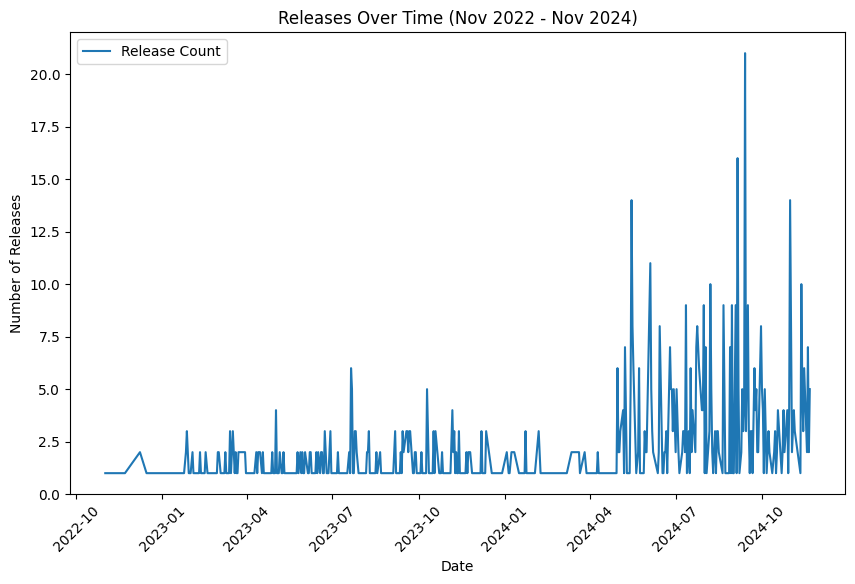

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0052 - val_loss: 0.0417
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - val_loss: 0.0398
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049 - val_loss: 0.0393
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - val_loss: 0.0386
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 0.0387
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073 - val_loss: 0.0392
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - val_loss: 0.0386
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - val_loss: 0.0386
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0384
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - val_loss: 0.0381
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - val_loss: 0.0378
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049

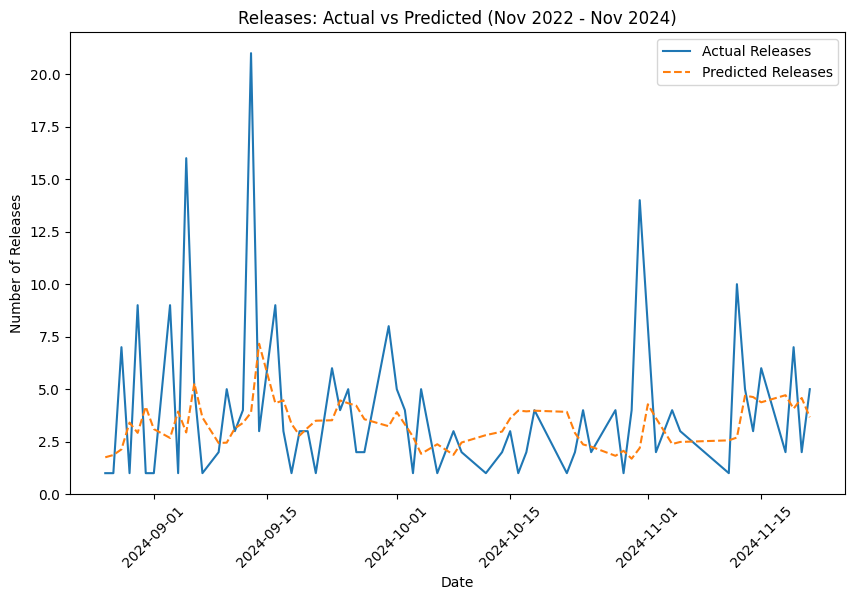

In [10]:
# Assuming you have fetched release data into a DataFrame
df_releases = pd.read_csv("github_all_data.csv")

# Convert the 'published_at' field to datetime
df_releases['published_at'] = pd.to_datetime(df_releases['published_at'])

# Filter data between Nov 2022 and Nov 2024 (adjust as needed)
df_releases = df_releases[(df_releases['published_at'] >= start_date) & (df_releases['published_at'] <= end_date)]

# Group by the 'published_at' date and count the number of releases
df_releases_daily = df_releases.groupby(df_releases['published_at'].dt.date).size().reset_index(name='release_count')

# Plot the release data over time
plt.figure(figsize=(10, 6))
plt.plot(df_releases_daily['published_at'], df_releases_daily['release_count'], label='Release Count')
plt.xlabel('Date')
plt.ylabel('Number of Releases')
plt.title('Releases Over Time (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Prepare the time series data for LSTM
releases_values = df_releases_daily['release_count'].values.reshape(-1, 1)

# Normalize the data
scaler_releases = MinMaxScaler(feature_range=(0, 1))
releases_scaled = scaler_releases.fit_transform(releases_values)

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(releases_scaled) * 0.8)
train_data, test_data = releases_scaled[:train_size], releases_scaled[train_size:]

# Create the dataset for LSTM (X, y)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Reshape data into the form that can be used by LSTM (samples, time steps, features)
time_step = 30  # Use the past 30 days to predict the next day's releases
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model_releases = Sequential()
model_releases.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_releases.add(Dense(units=1))

# Compile the model
model_releases.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_releases.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict the releases on the test set
predicted_releases = model_releases.predict(X_test)

# Inverse transform the predicted values to get them back to original scale
predicted_releases = scaler_releases.inverse_transform(predicted_releases)

# Inverse transform the actual values to get them back to original scale
y_test_actual = scaler_releases.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs predicted releases
plt.figure(figsize=(10, 6))
plt.plot(df_releases_daily['published_at'][-len(y_test_actual):], y_test_actual, label='Actual Releases')
plt.plot(df_releases_daily['published_at'][-len(predicted_releases):], predicted_releases, label='Predicted Releases', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Releases')
plt.title('Releases: Actual vs Predicted (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig("forecasting/Tensorflow_LSTM/releases_forecast.png")
plt.show()


<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 9 (FACEBOOK/PROPHET)
- Use Facebook/Prophet package to forecast the following for every repository
    
</div>

<div class="alert alert-block alert-warning">   
    
#### REQ9-1). The day of the week maximum number of issues created 
    
</div>

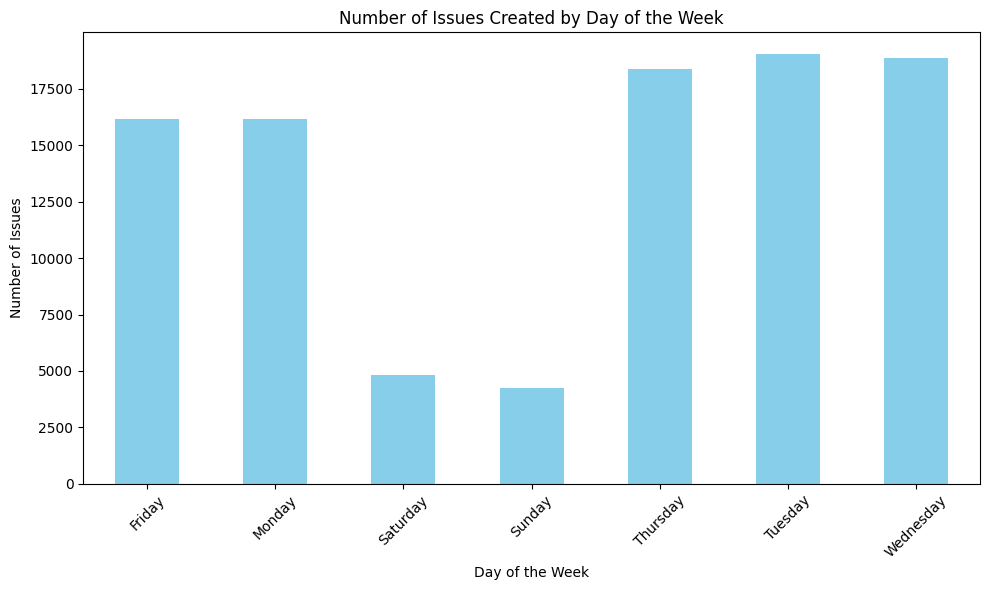

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load your dataset
df = pd.read_csv("github_all_data.csv")

# Ensure 'created_at' is converted to datetime
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Check if the datetime is timezone-aware, and localize to UTC if not
if df['created_at'].dt.tz is None:
    df['created_at'] = df['created_at'].dt.tz_localize('UTC')
else:
    df['created_at'] = df['created_at'].dt.tz_convert('UTC')

# Remove timezone information from 'created_at' before using Prophet
df['created_at'] = df['created_at'].dt.tz_localize(None)

# Filter data for the past 2 years
end_date = pd.to_datetime('2024-11-21')
start_date = end_date - pd.DateOffset(years=2)

# Filter the dataframe for the relevant date range
df = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]

# Drop any rows with NaN values in relevant columns
df = df.dropna(subset=['created_at', 'repository', 'type'])

# Get the day of the week when issues were created
df['day_of_week'] = df['created_at'].dt.day_name()

# Count issues created each day of the week
day_of_week_counts = df['day_of_week'].value_counts().sort_index()

# Plot the day of the week with the most issues created
plt.figure(figsize=(10, 6))
day_of_week_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Issues Created by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Issues")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasting/Prophet/number_of_issues_created.png")
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-2). The day of the week maximum number of issues closed 

</div>

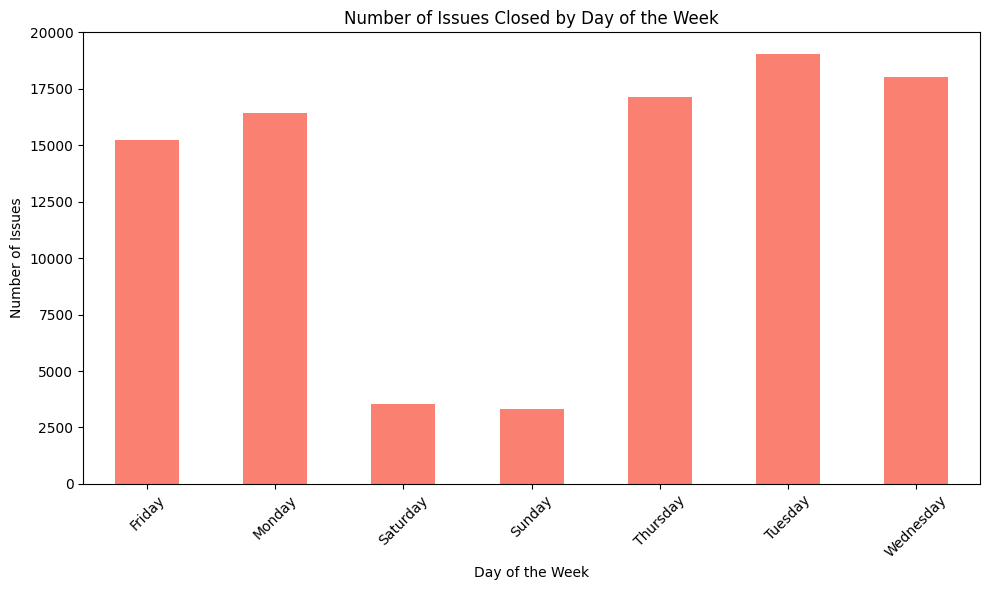

In [12]:
#Add your code for requirement 9.2 in this cell

# Ensure 'closed_at' is converted to datetime
df['closed_at'] = pd.to_datetime(df['closed_at'], errors='coerce')

# Check if the datetime is timezone-aware, and localize to UTC if not
if df['closed_at'].dt.tz is None:
    df['closed_at'] = df['closed_at'].dt.tz_localize('UTC')
else:
    df['closed_at'] = df['closed_at'].dt.tz_convert('UTC')

# Remove timezone information from 'closed_at' before using Prophet
df['closed_at'] = df['closed_at'].dt.tz_localize(None)

# Filter data for the past 2 years
df = df[(df['closed_at'] >= start_date) & (df['closed_at'] <= end_date)]

# Drop any rows with NaN values in relevant columns
df = df.dropna(subset=['closed_at', 'repository', 'type'])

# Get the day of the week when issues were closed
df['closed_day_of_week'] = df['closed_at'].dt.day_name()

# Count issues closed each day of the week
closed_day_of_week_counts = df['closed_day_of_week'].value_counts().sort_index()

# Plot the day of the week with the most issues closed
plt.figure(figsize=(10, 6))
closed_day_of_week_counts.plot(kind='bar', color='salmon')
plt.title("Number of Issues Closed by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Issues")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasting/Prophet/number_of_issues_closed.png")
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-3). The month of the year that has maximum number of issues closed 


</div>

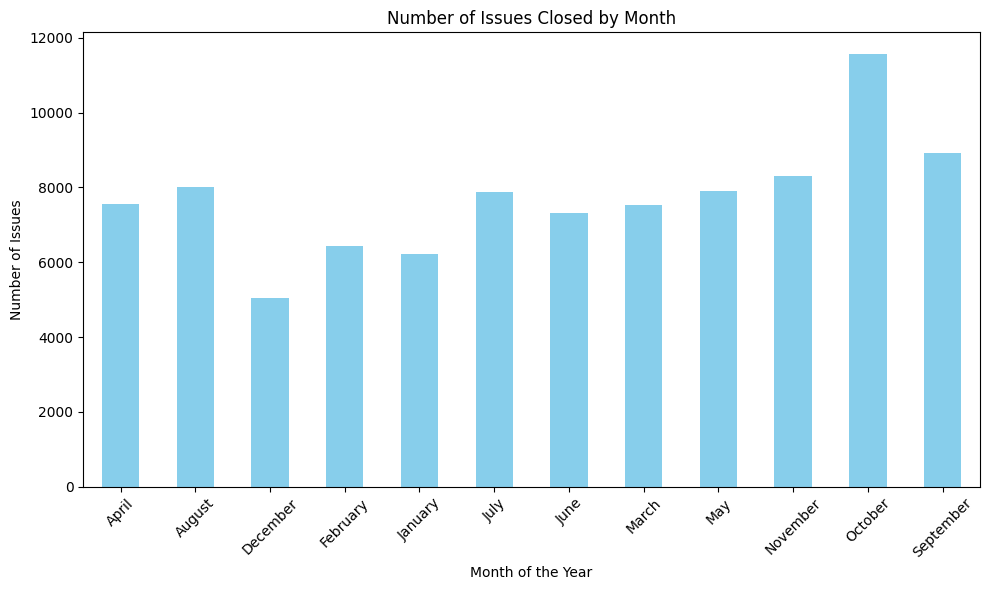

In [13]:
#Add your code for requirement 9.3 in this cell
# Ensure 'closed_at' is converted to datetime
df['closed_at'] = pd.to_datetime(df['closed_at'], errors='coerce')

# Check if the datetime is timezone-aware, and localize to UTC if not
if df['closed_at'].dt.tz is None:
    df['closed_at'] = df['closed_at'].dt.tz_localize('UTC')
else:
    df['closed_at'] = df['closed_at'].dt.tz_convert('UTC')

# Remove timezone information from 'closed_at' before using Prophet
df['closed_at'] = df['closed_at'].dt.tz_localize(None)

# Filter data for the past 2 years
df = df[(df['closed_at'] >= start_date) & (df['closed_at'] <= end_date)]

# Drop any rows with NaN values in relevant columns
df = df.dropna(subset=['closed_at', 'repository', 'type'])

# Get the month of the year when issues were closed
df['closed_month'] = df['closed_at'].dt.month_name()

# Count issues closed each month
closed_month_counts = df['closed_month'].value_counts().sort_index()

# Plot the month with the most issues closed
plt.figure(figsize=(10, 6))
closed_month_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Issues Closed by Month")
plt.xlabel("Month of the Year")
plt.ylabel("Number of Issues")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasting/Prophet/max_number_of_issues_closed_by_month.png")
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-4). Plot the created issues forecast 

</div>

22:34:39 - cmdstanpy - INFO - Chain [1] start processing
22:34:40 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

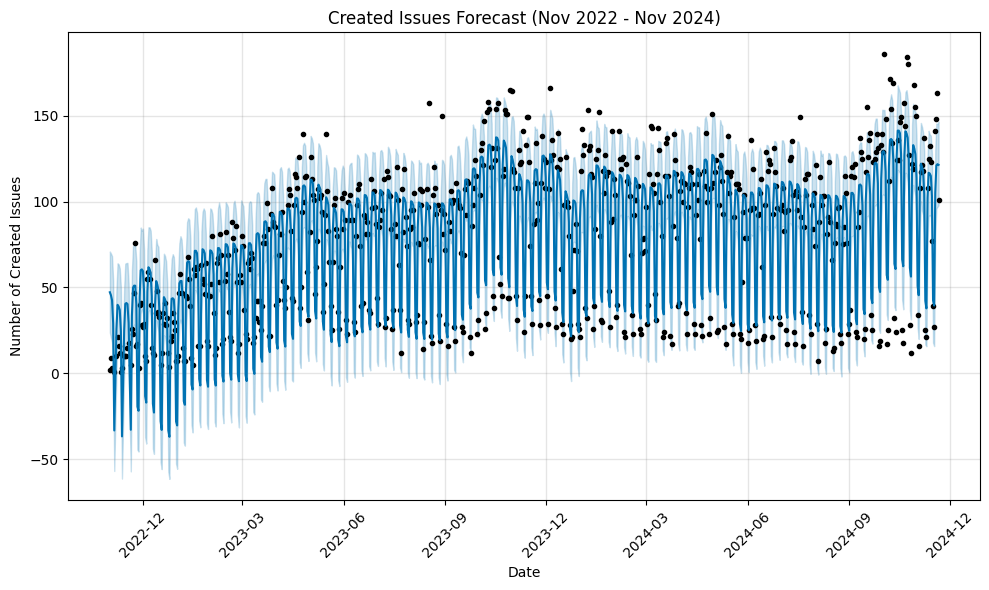

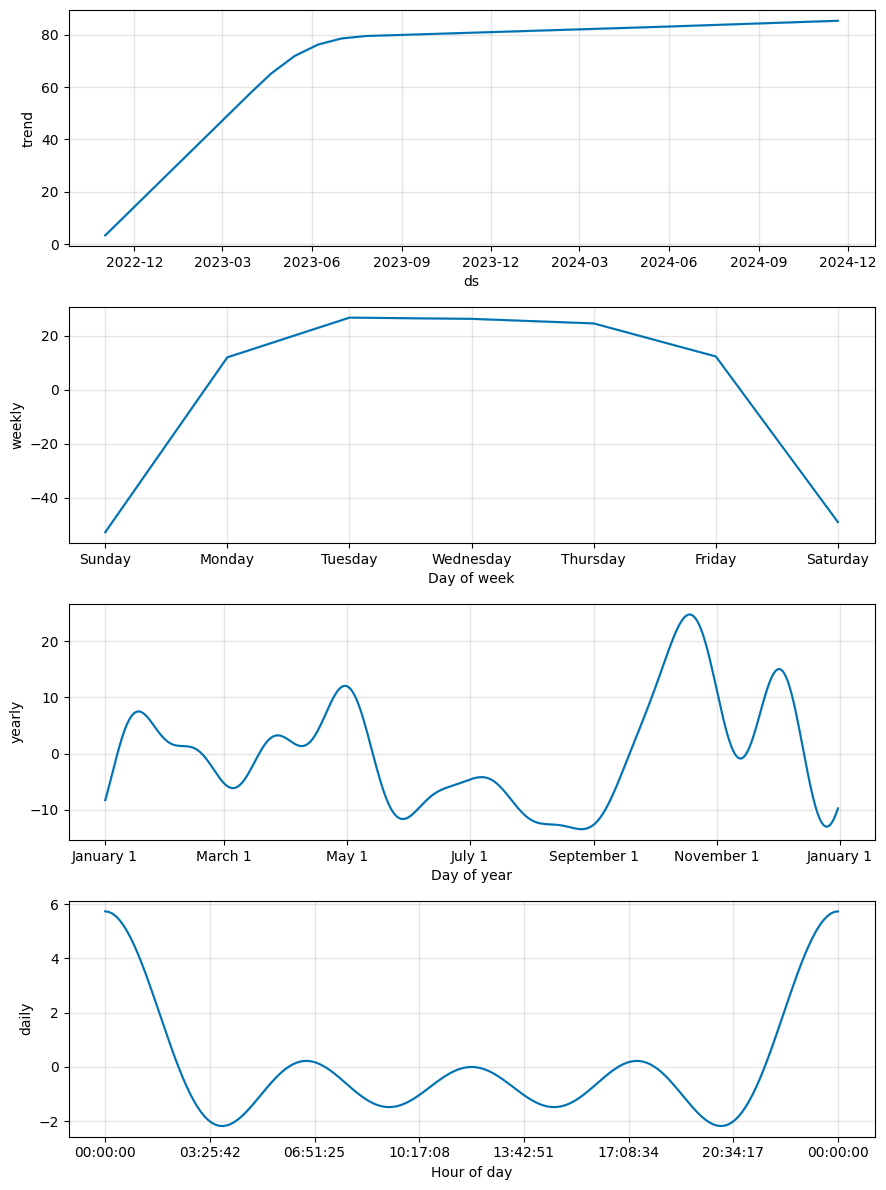

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'issue' type and 'created' status
df_created_issues = df_detailed[df_detailed['type'] == 'issue']

# Convert 'created_at' to datetime
df_created_issues['created_at'] = pd.to_datetime(df_created_issues['created_at'])

# Filter data between November 2022 and November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_created_issues = df_created_issues[(df_created_issues['created_at'] >= start_date) & (df_created_issues['created_at'] <= end_date)]

# Extract the date part (ignoring time) and group by date to count created issues
df_created_issues['date'] = df_created_issues['created_at'].dt.date
df_created_daily = df_created_issues.groupby('date').size().reset_index(name='created_issue_count')

# Prepare the data for Prophet (Prophet expects columns 'ds' for date and 'y' for the values to forecast)
prophet_df = df_created_daily.rename(columns={'date': 'ds', 'created_issue_count': 'y'})

# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

# Forecast the data based on existing dates
forecast = model.predict(prophet_df)

# Plot the created issues forecast
plt.figure(figsize=(10, 6))
model.plot(forecast)
plt.title('Created Issues Forecast (Nov 2022 - Nov 2024)')
plt.xlabel('Date')
plt.ylabel('Number of Created Issues')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasting/Prophet/created_issues_forecast.png")
plt.show()

# Optional: Plot forecast components (trend, yearly, and weekly seasonality)
model.plot_components(forecast)
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-5). Plot the closed issues forecast 

</div>

22:35:07 - cmdstanpy - INFO - Chain [1] start processing
22:35:07 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

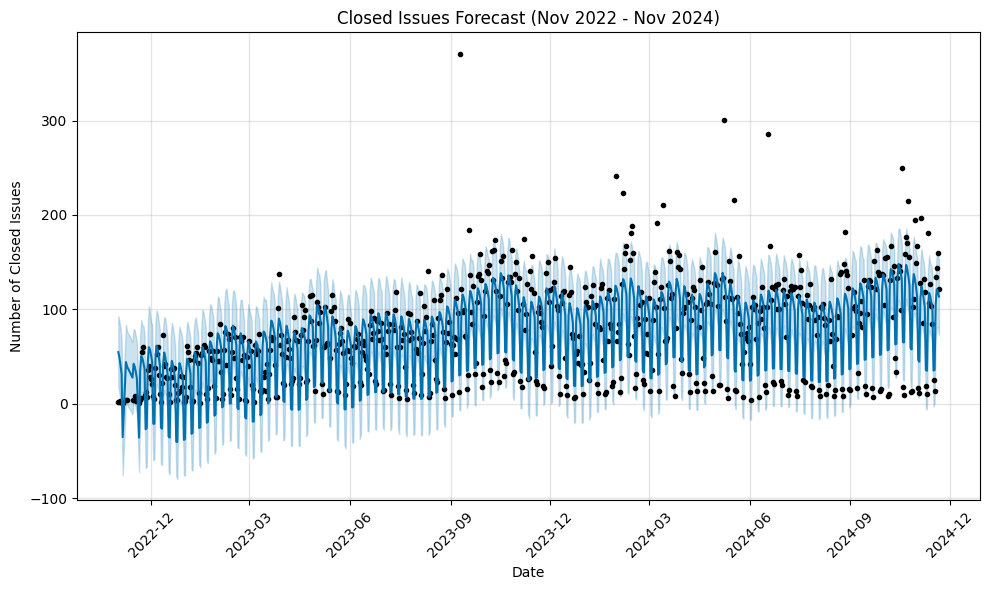

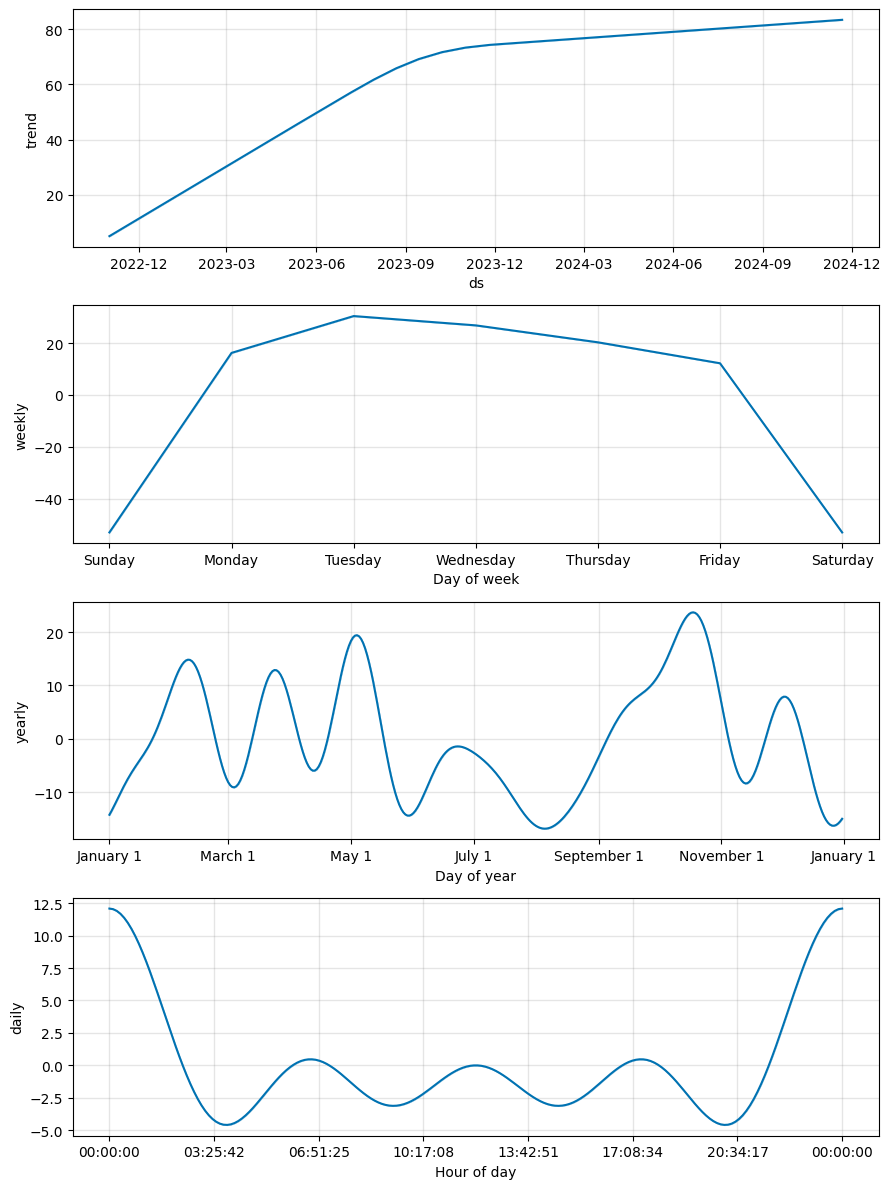

In [15]:
#Add your code for requirement 9.5 in this cell

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'issue' type and 'closed' status
df_closed_issues = df_detailed[df_detailed['type'] == 'issue']
df_closed_issues = df_closed_issues[df_closed_issues['state'] == 'closed']

# Convert 'closed_at' to datetime
df_closed_issues['closed_at'] = pd.to_datetime(df_closed_issues['closed_at'])

# Filter data between November 2022 and November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_closed_issues = df_closed_issues[(df_closed_issues['closed_at'] >= start_date) & (df_closed_issues['closed_at'] <= end_date)]

# Extract the date part (ignoring time) and group by date to count closed issues
df_closed_issues['date'] = df_closed_issues['closed_at'].dt.date
df_closed_daily = df_closed_issues.groupby('date').size().reset_index(name='closed_issue_count')

# Prepare the data for Prophet (Prophet expects columns 'ds' for date and 'y' for the values to forecast)
prophet_df_closed = df_closed_daily.rename(columns={'date': 'ds', 'closed_issue_count': 'y'})

# Initialize and fit the Prophet model
model_closed_issues = Prophet(daily_seasonality=True)
model_closed_issues.fit(prophet_df_closed)

# Forecast the data based on existing dates
forecast_closed = model_closed_issues.predict(prophet_df_closed)

# Plot the closed issues forecast
plt.figure(figsize=(10, 6))
model_closed_issues.plot(forecast_closed)
plt.title('Closed Issues Forecast (Nov 2022 - Nov 2024)')
plt.xlabel('Date')
plt.ylabel('Number of Closed Issues')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasting/Prophet/closed_issues_forecast.png")
plt.show()

# Optional: Plot forecast components (trend, yearly, and weekly seasonality)
model_closed_issues.plot_components(forecast_closed)
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-6). Plot the pulls forecast 

</div>

22:35:25 - cmdstanpy - INFO - Chain [1] start processing
22:35:25 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

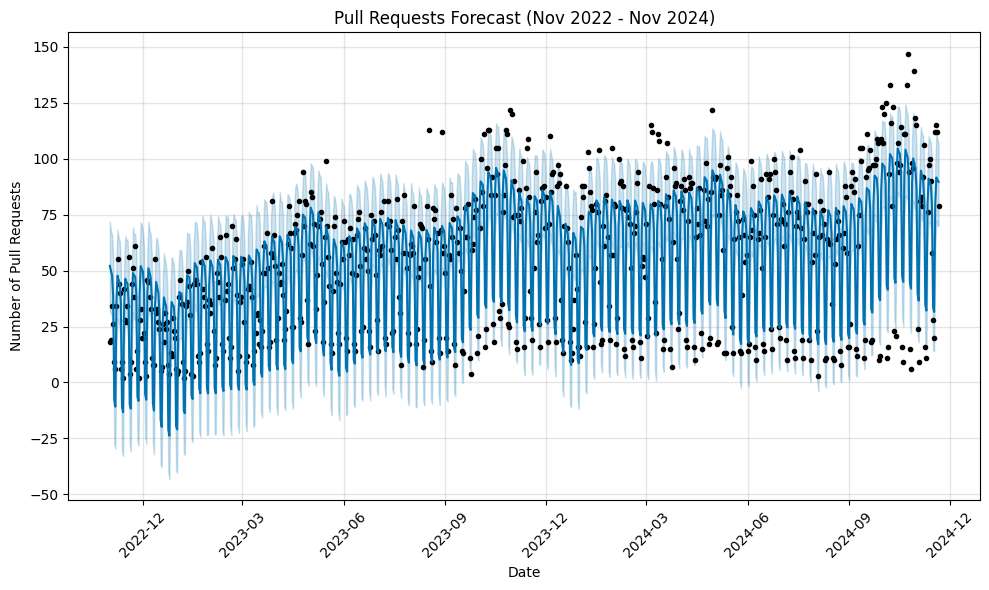

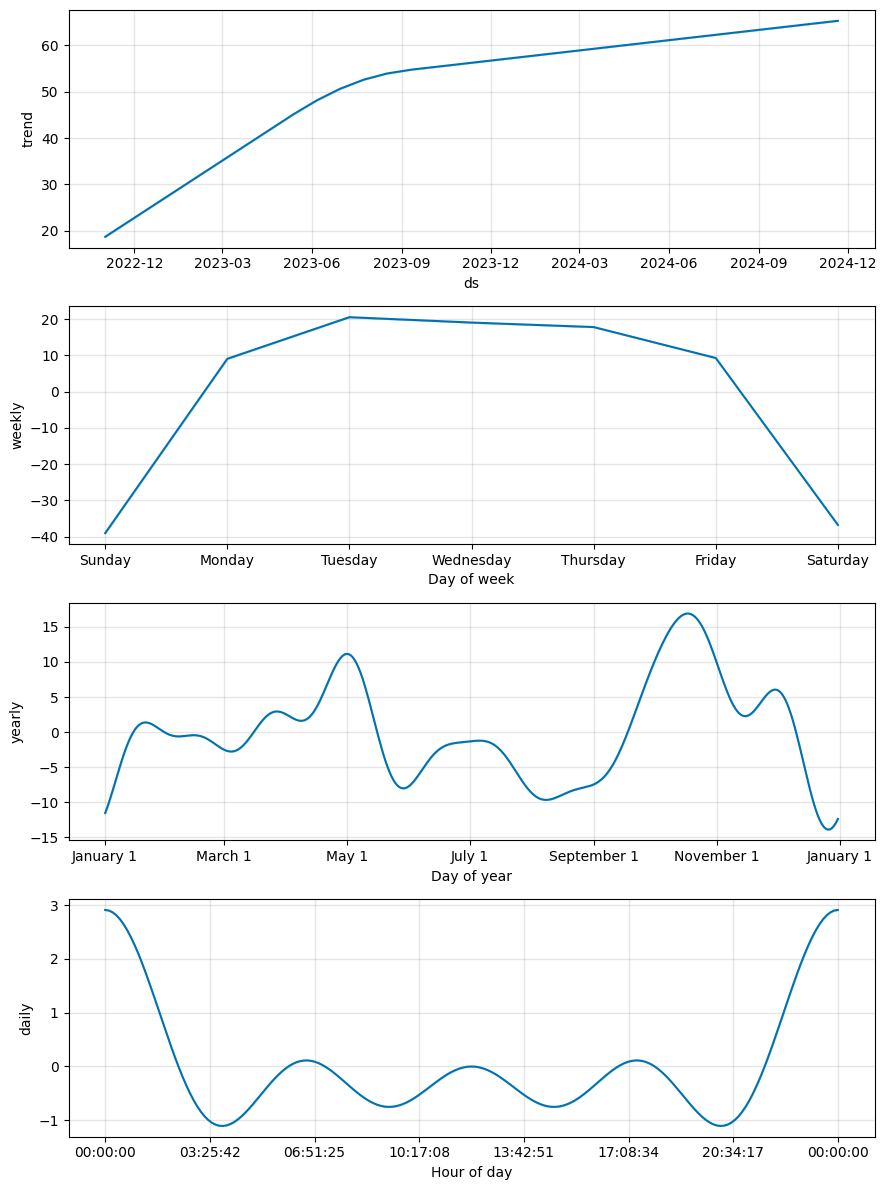

In [16]:
#Add your code for requirement 9.6 in this cell

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'pull_request' type
df_pulls = df_detailed[df_detailed['type'] == 'pull_request']

# Convert 'created_at' to datetime (assuming pulls have 'created_at' column)
df_pulls['created_at'] = pd.to_datetime(df_pulls['created_at'])

# Filter data between November 2022 and November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_pulls = df_pulls[(df_pulls['created_at'] >= start_date) & (df_pulls['created_at'] <= end_date)]

# Extract the date part (ignoring time) and group by date to count pull requests
df_pulls['date'] = df_pulls['created_at'].dt.date
df_pulls_daily = df_pulls.groupby('date').size().reset_index(name='pull_request_count')

# Prepare the data for Prophet (Prophet expects columns 'ds' for date and 'y' for the values to forecast)
prophet_df_pulls = df_pulls_daily.rename(columns={'date': 'ds', 'pull_request_count': 'y'})

# Initialize and fit the Prophet model
model_pulls = Prophet(daily_seasonality=True)
model_pulls.fit(prophet_df_pulls)

# Forecast the data based on existing dates
forecast_pulls = model_pulls.predict(prophet_df_pulls)

# Plot the pull requests forecast
plt.figure(figsize=(10, 6))
model_pulls.plot(forecast_pulls)
plt.title('Pull Requests Forecast (Nov 2022 - Nov 2024)')
plt.xlabel('Date')
plt.ylabel('Number of Pull Requests')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasting/Prophet/pulls_forecast.png")
plt.show()

# Optional: Plot forecast components (trend, yearly, and weekly seasonality)
model_pulls.plot_components(forecast_pulls)
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-7). Plot the commits forecast

</div>

22:35:44 - cmdstanpy - INFO - Chain [1] start processing
22:35:44 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

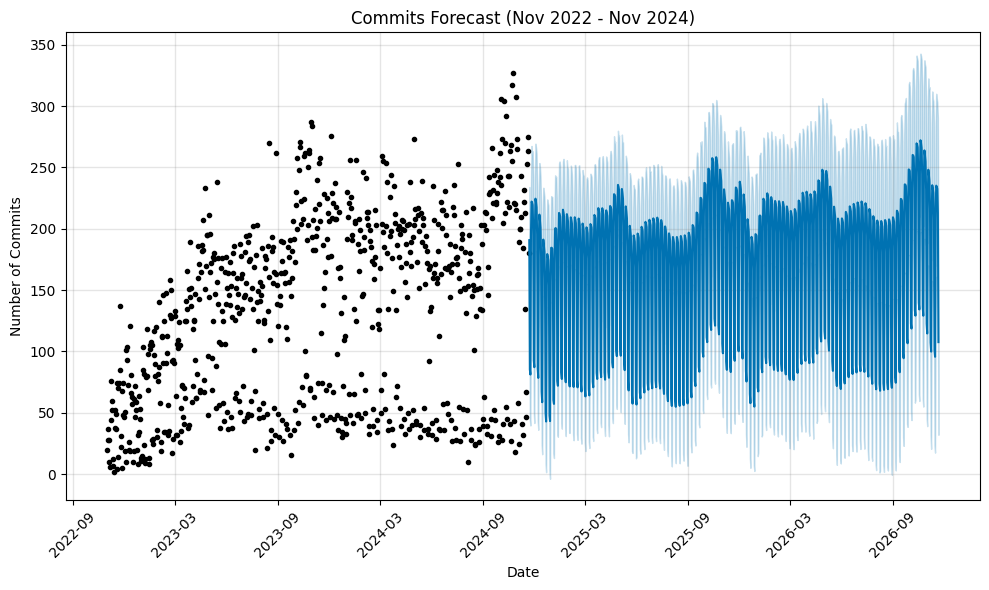

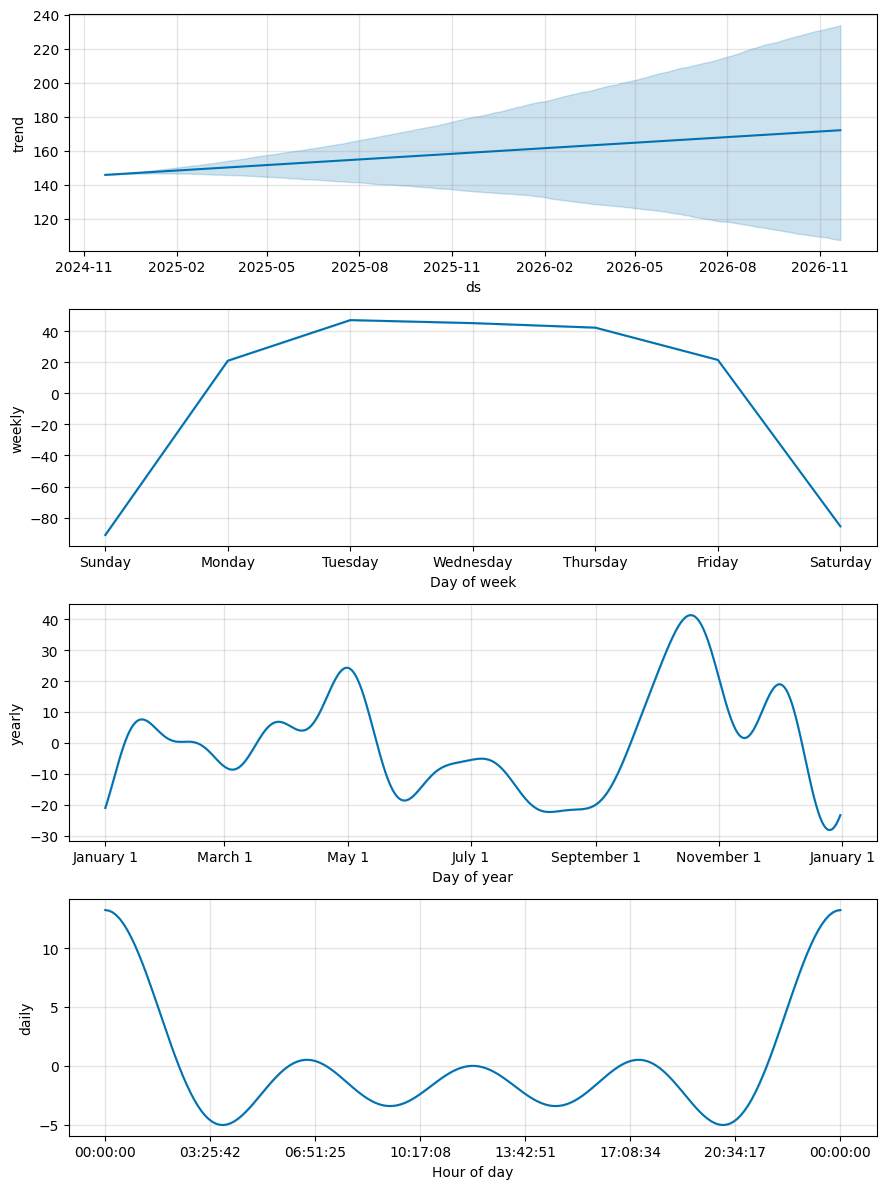

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the data
df_commits = pd.read_csv("github_all_data.csv")

# Extract commit date (assuming the 'created_at' column contains commit timestamp)
df_commits['created_at'] = pd.to_datetime(df_commits['created_at'])

# Filter commits from November 2022 to November 2024 (adjust dates if needed)
start_date = '2022-11-01'
end_date = '2024-11-30'
df_commits = df_commits[(df_commits['created_at'] >= start_date) & (df_commits['created_at'] <= end_date)]

# Group by date and count the number of commits per day
df_commits['date'] = df_commits['created_at'].dt.date
df_commits_daily = df_commits.groupby('date').size().reset_index(name='commit_count')

# Prepare the data for Prophet (Prophet expects columns 'ds' for date and 'y' for the values to forecast)
prophet_df_commits = df_commits_daily.rename(columns={'date': 'ds', 'commit_count': 'y'})

# Initialize the Prophet model
model_commits = Prophet(daily_seasonality=True)

# Fit the model with the historical data
model_commits.fit(prophet_df_commits)

# Create a custom date range for the future predictions (next 2 years)
# For example, from the last date in the dataset, generate a list of future dates
last_date = prophet_df_commits['ds'].max()
future_dates = pd.date_range(start=last_date, periods=365*2 + 1, freq='D')[1:]

# Prepare the dataframe for future dates
future_df = pd.DataFrame(future_dates, columns=['ds'])

# Forecast the future values
forecast_commits = model_commits.predict(future_df)

# Plot the commits forecast
plt.figure(figsize=(10, 6))
model_commits.plot(forecast_commits)
plt.title('Commits Forecast (Nov 2022 - Nov 2024)')
plt.xlabel('Date')
plt.ylabel('Number of Commits')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasting/Prophet/commits_forecast.png")
plt.show()

# Optional: Plot forecast components (trend, yearly, and weekly seasonality)
model_commits.plot_components(forecast_commits)
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-8). Plot the branches forecast

</div>

22:35:58 - cmdstanpy - INFO - Chain [1] start processing
22:35:58 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

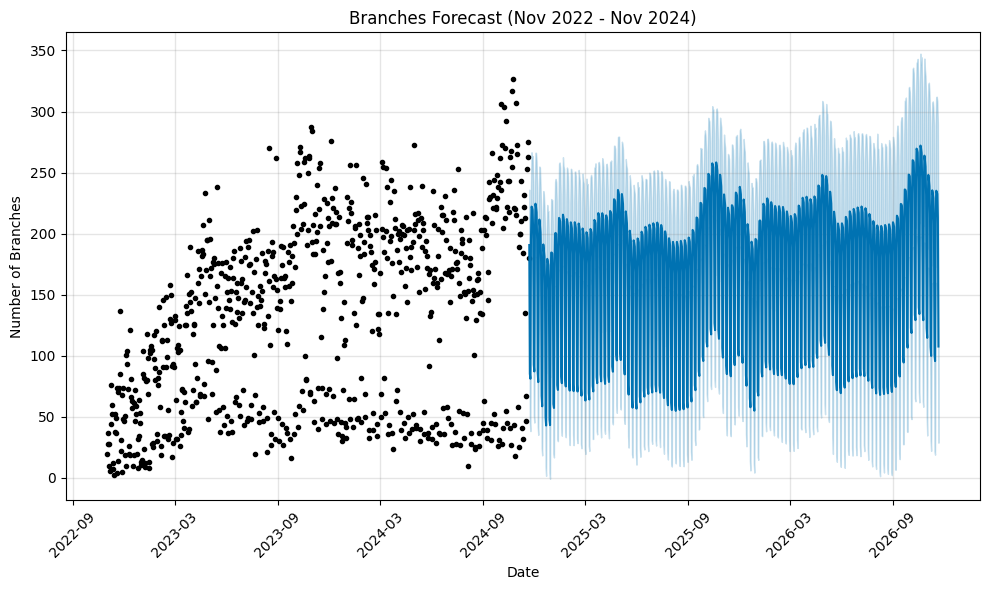

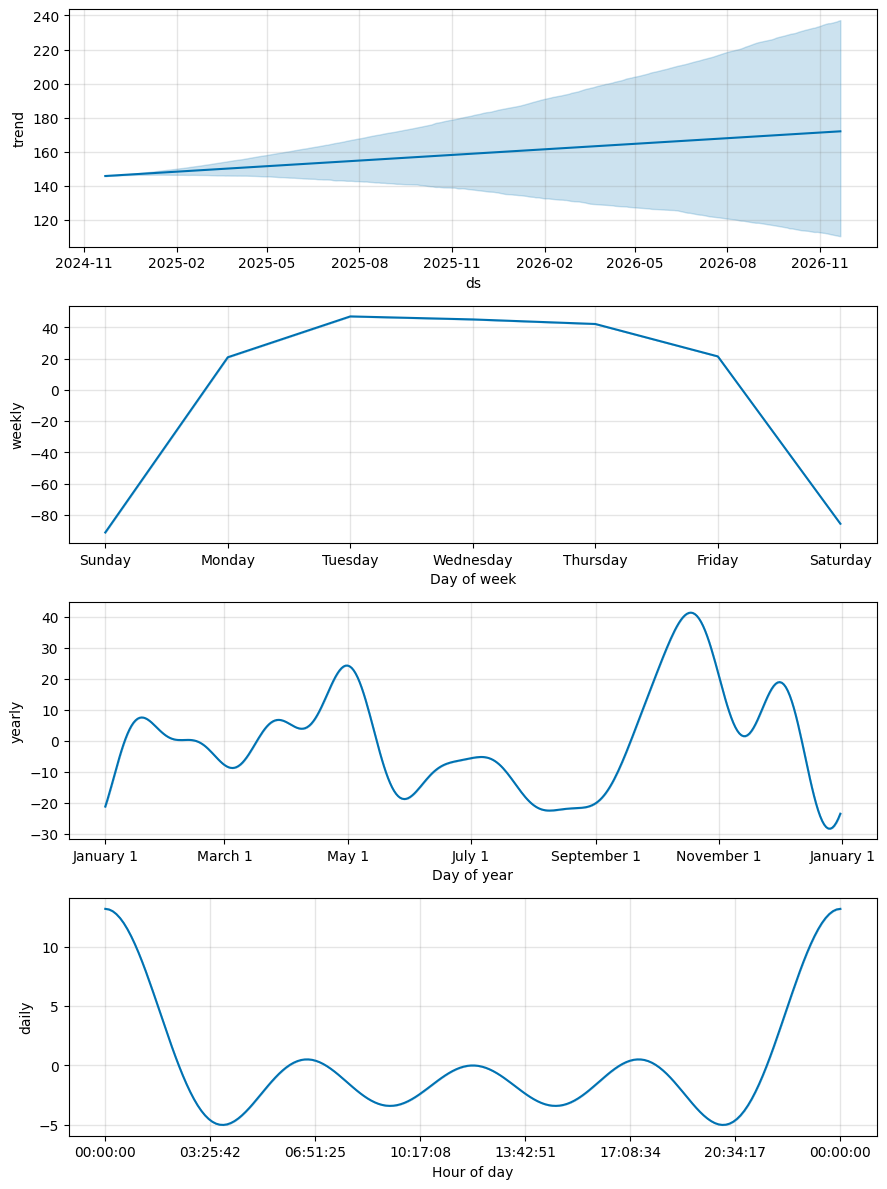

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the data
df_branches = pd.read_csv("github_all_data.csv")

# Assuming there is a 'branch' or 'ref' column to track branch names
# Extract the date (assuming 'created_at' column contains timestamp)
df_branches['created_at'] = pd.to_datetime(df_branches['created_at'])

# Filter data between Nov 2022 and Nov 2024 (adjust as necessary)
start_date = '2022-11-01'
end_date = '2024-11-30'
df_branches = df_branches[(df_branches['created_at'] >= start_date) & (df_branches['created_at'] <= end_date)]

# Filter for the 'branch' column (assuming it exists)
# Group by date and count the number of branches per day
df_branches['date'] = df_branches['created_at'].dt.date
df_branches_daily = df_branches.groupby('date').size().reset_index(name='branch_count')

# Prepare the data for Prophet (Prophet expects columns 'ds' for date and 'y' for the values to forecast)
prophet_df_branches = df_branches_daily.rename(columns={'date': 'ds', 'branch_count': 'y'})

# Initialize the Prophet model
model_branches = Prophet(daily_seasonality=True)

# Fit the model with the historical data
model_branches.fit(prophet_df_branches)

# Create a custom date range for the future predictions (next 2 years)
# For example, from the last date in the dataset, generate a list of future dates
last_date = prophet_df_branches['ds'].max()
future_dates = pd.date_range(start=last_date, periods=365*2 + 1, freq='D')[1:]

# Prepare the dataframe for future dates
future_df = pd.DataFrame(future_dates, columns=['ds'])

# Forecast the future values
forecast_branches = model_branches.predict(future_df)

# Plot the branches forecast
plt.figure(figsize=(10, 6))
model_branches.plot(forecast_branches)
plt.title('Branches Forecast (Nov 2022 - Nov 2024)')
plt.xlabel('Date')
plt.ylabel('Number of Branches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasting/Prophet/branches_forecast.png")
plt.show()

# Optional: Plot forecast components (trend, yearly, and weekly seasonality)
model_branches.plot_components(forecast_branches)
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-9). Plot the contributors forecast

</div>

22:36:17 - cmdstanpy - INFO - Chain [1] start processing
22:36:18 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

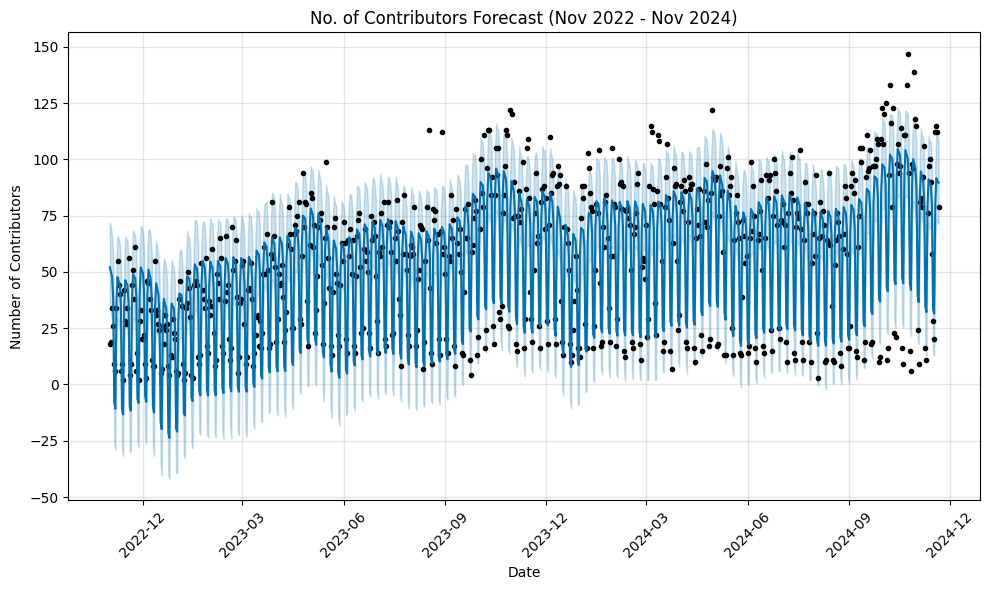

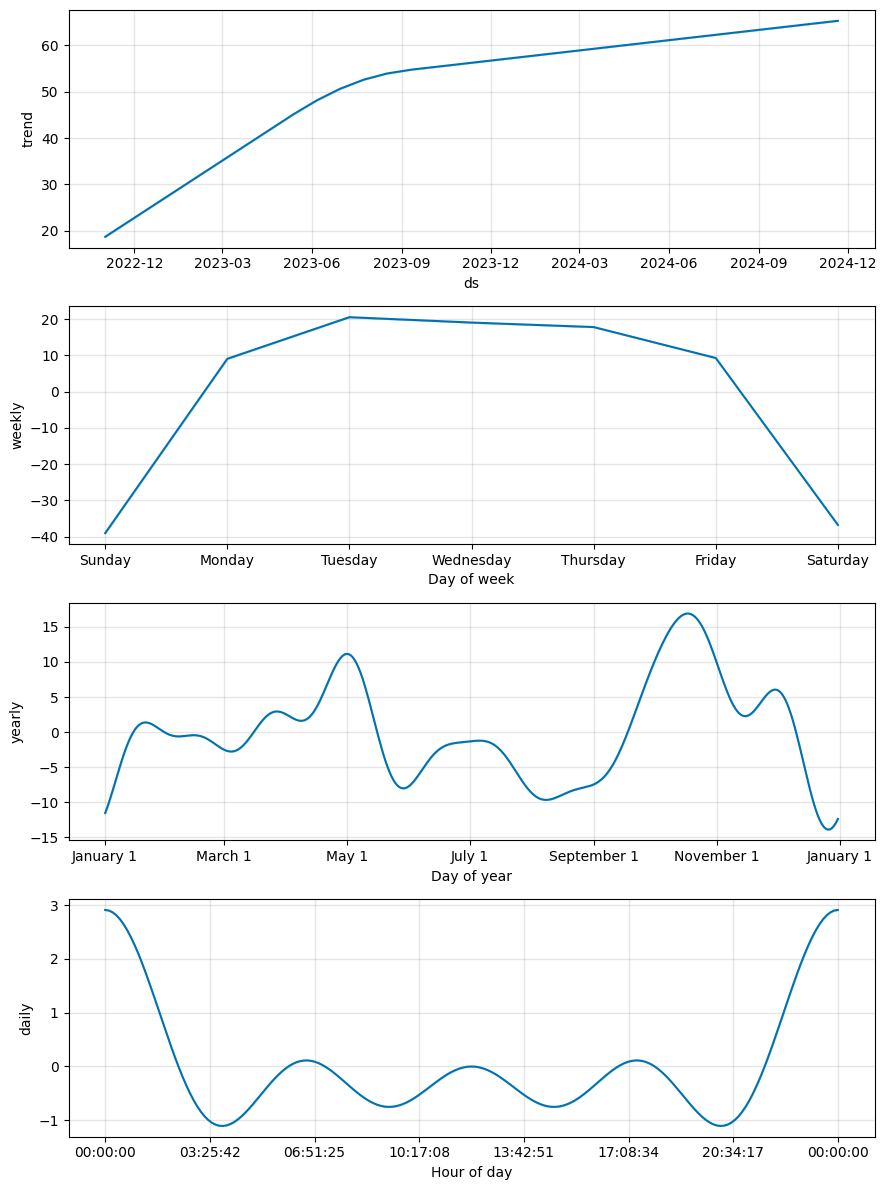

In [19]:
#Add your code for requirement 9.9 in this cell

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'pull_request' type
df_pulls = df_detailed[df_detailed['type'] == 'pull_request']

# Convert 'created_at' to datetime (assuming pulls have 'created_at' column)
df_pulls['created_at'] = pd.to_datetime(df_pulls['created_at'])

# Filter data between November 2022 and November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_pulls = df_pulls[(df_pulls['created_at'] >= start_date) & (df_pulls['created_at'] <= end_date)]

# Extract the date part (ignoring time) and group by date to count pull requests
df_pulls['date'] = df_pulls['created_at'].dt.date
df_pulls_daily = df_pulls.groupby('date').size().reset_index(name='pull_request_count')

# Prepare the data for Prophet (Prophet expects columns 'ds' for date and 'y' for the values to forecast)
prophet_df_pulls = df_pulls_daily.rename(columns={'date': 'ds', 'pull_request_count': 'y'})

# Initialize and fit the Prophet model
model_pulls = Prophet(daily_seasonality=True)
model_pulls.fit(prophet_df_pulls)

# Forecast the data based on existing dates
forecast_pulls = model_pulls.predict(prophet_df_pulls)

# Plot the pull requests forecast
plt.figure(figsize=(10, 6))
model_pulls.plot(forecast_pulls)
plt.title('No. of Contributors Forecast (Nov 2022 - Nov 2024)')
plt.xlabel('Date')
plt.ylabel('Number of Contributors')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasting/Prophet/contributors_forecast.png")
plt.show()

# Optional: Plot forecast components (trend, yearly, and weekly seasonality)
model_pulls.plot_components(forecast_pulls)
plt.show()


<div class="alert alert-block alert-warning">   
    
#### REQ9-10). Plot the releases forecast

</div>

22:36:34 - cmdstanpy - INFO - Chain [1] start processing
22:36:34 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

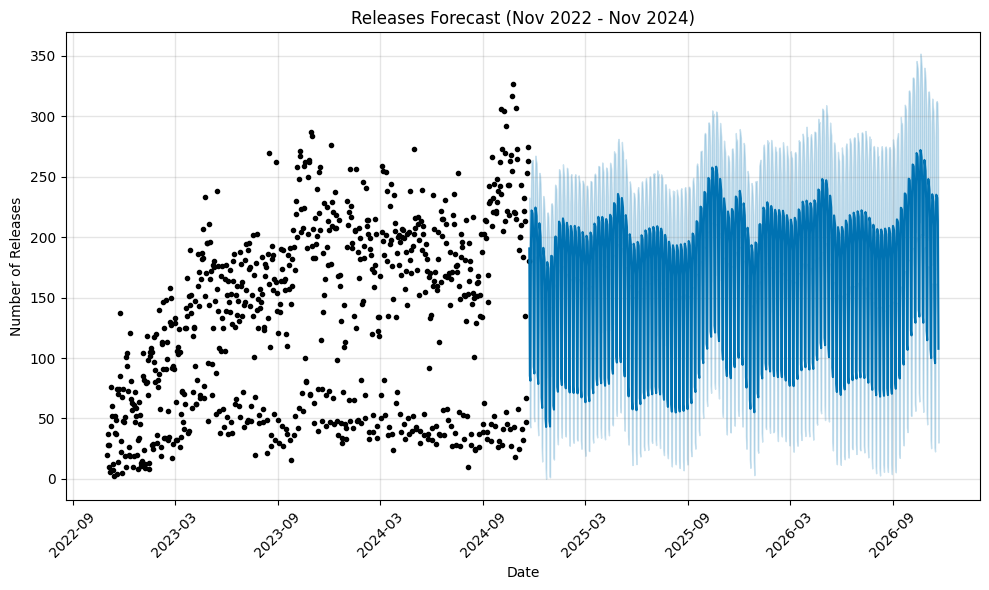

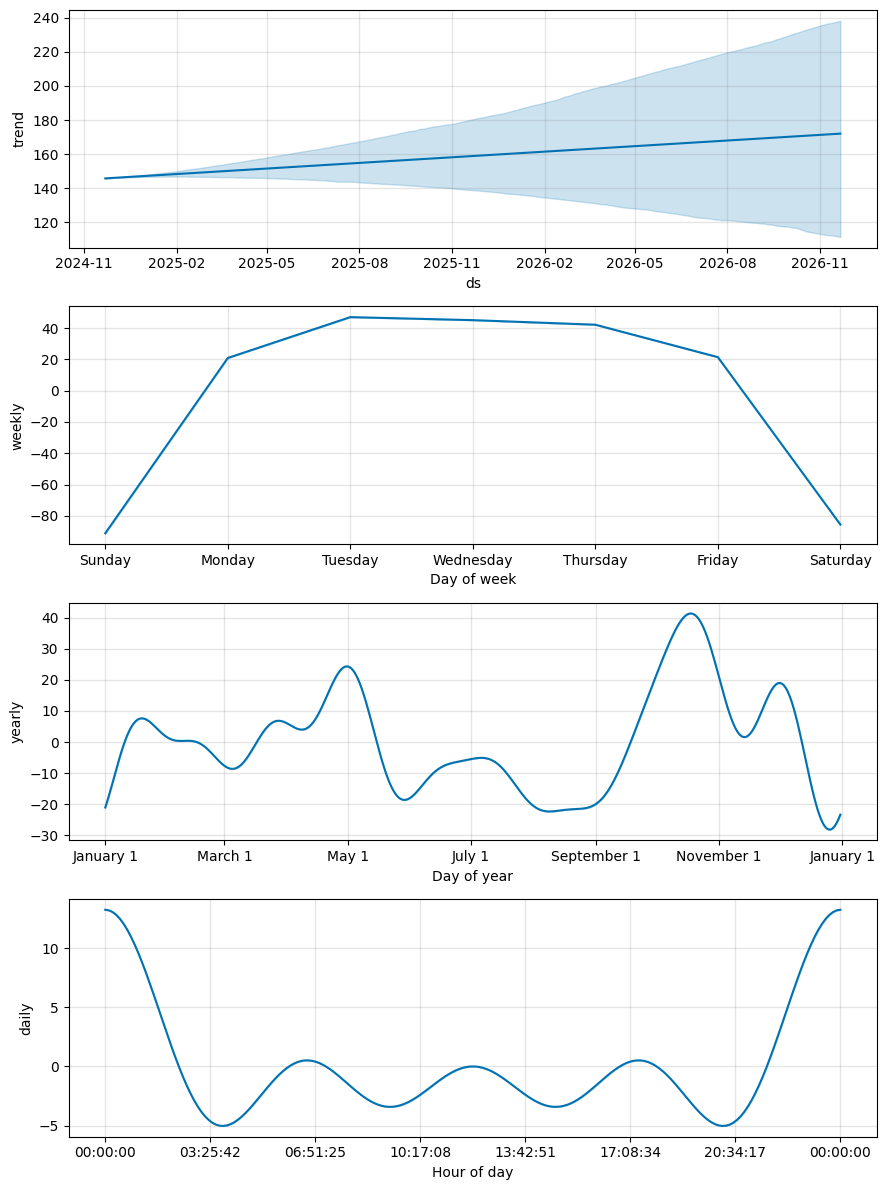

In [20]:
#Add your code for requirement 9.10 in this cell

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the data
df_releases = pd.read_csv("github_all_data.csv")

# Assuming there is a 'release' or similar column to track releases (adjust the column name if necessary)
# Extract the date (assuming 'created_at' column contains timestamp)
df_releases['created_at'] = pd.to_datetime(df_releases['created_at'])

# Filter data between Nov 2022 and Nov 2024 (adjust as necessary)
start_date = '2022-11-01'
end_date = '2024-11-30'
df_releases = df_releases[(df_releases['created_at'] >= start_date) & (df_releases['created_at'] <= end_date)]

# Filter for the 'release' column (assuming it exists and tracks releases)
# Group by date and count the number of releases per day
df_releases['date'] = df_releases['created_at'].dt.date
df_releases_daily = df_releases.groupby('date').size().reset_index(name='release_count')

# Prepare the data for Prophet (Prophet expects columns 'ds' for date and 'y' for the values to forecast)
prophet_df_releases = df_releases_daily.rename(columns={'date': 'ds', 'release_count': 'y'})

# Initialize the Prophet model
model_releases = Prophet(daily_seasonality=True)

# Fit the model with the historical data
model_releases.fit(prophet_df_releases)

# Create a custom date range for the future predictions (next 2 years)
# For example, from the last date in the dataset, generate a list of future dates
last_date = prophet_df_releases['ds'].max()
future_dates = pd.date_range(start=last_date, periods=365*2 + 1, freq='D')[1:]

# Prepare the dataframe for future dates
future_df = pd.DataFrame(future_dates, columns=['ds'])

# Forecast the future values
forecast_releases = model_releases.predict(future_df)

# Plot the releases forecast
plt.figure(figsize=(10, 6))
model_releases.plot(forecast_releases)
plt.title('Releases Forecast (Nov 2022 - Nov 2024)')
plt.xlabel('Date')
plt.ylabel('Number of Releases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("forecasting/Prophet/releases_forecast.png")
plt.show()

# Optional: Plot forecast components (trend, yearly, and weekly seasonality)
model_releases.plot_components(forecast_releases)
plt.show()


<hr style="border:1px solid black"> </hr>
<div class="alert alert-info">   
    
## REQUIREMENT 10 (STATSMODEL)
- Use StatsModel package to forecast the following for every repository
    
</div>

<div class="alert alert-block alert-danger">   
    
#### REQ10-1). The day of the week maximum number of issues created 
    
</div>

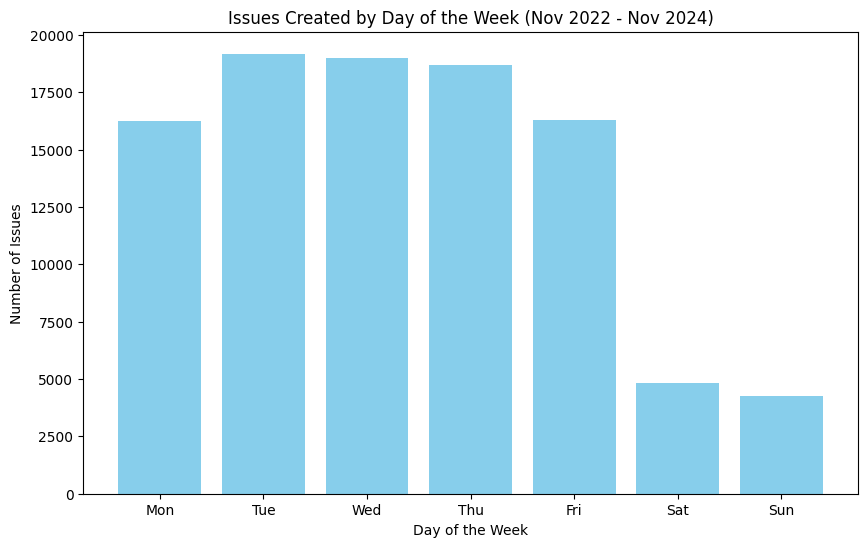

c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


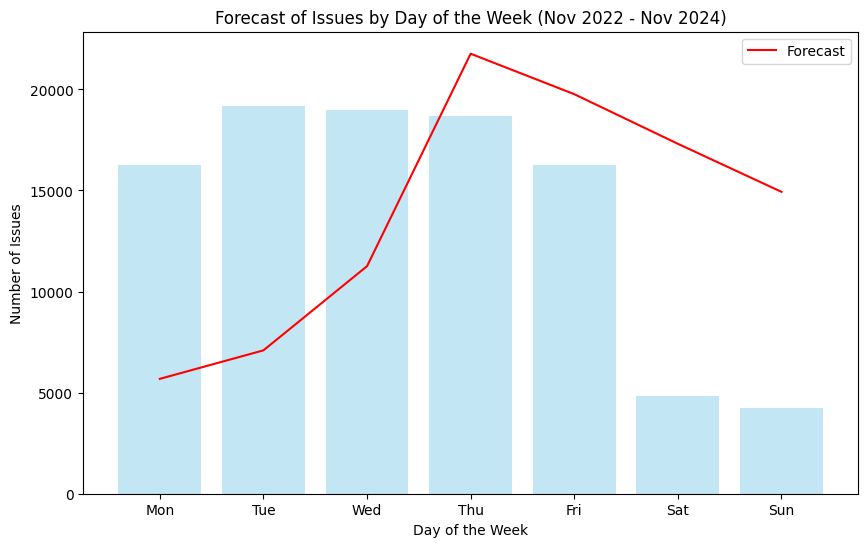

The day of the week with the maximum number of issues forecasted is: Thu


In [21]:
#Add your code for requirement 10.1 in this cell
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Load the data
df_issues = pd.read_csv("github_all_data.csv")

# Assuming there is a 'created_at' column with timestamps for when issues were created
df_issues['created_at'] = pd.to_datetime(df_issues['created_at'])

# Filter data between Nov 2022 and Nov 2024 (adjust as necessary)
start_date = '2022-11-01'
end_date = '2024-11-30'
df_issues = df_issues[(df_issues['created_at'] >= start_date) & (df_issues['created_at'] <= end_date)]

# Extract the day of the week (0 = Monday, 6 = Sunday)
df_issues['day_of_week'] = df_issues['created_at'].dt.dayofweek

# Group by 'day_of_week' and count the number of issues created on each day
issues_by_day = df_issues.groupby('day_of_week').size().reset_index(name='issue_count')

# Plot the issue count by day of the week
plt.figure(figsize=(10, 6))
plt.bar(issues_by_day['day_of_week'], issues_by_day['issue_count'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Issues')
plt.title('Issues Created by Day of the Week (Nov 2022 - Nov 2024)')
plt.xticks(issues_by_day['day_of_week'], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Prepare the time series data for ARIMA
# Assume we want to predict the maximum number of issues on the weekdays (0 = Monday, ..., 6 = Sunday)
# Reshape the data to fit the ARIMA model
# The day of the week is categorical but we're treating the counts as time series for forecasting

# Aggregate the issues count on a daily basis
df_issues_daily = df_issues.groupby(df_issues['created_at'].dt.date)['day_of_week'].value_counts().unstack(fill_value=0)

# Forecasting for the next period using ARIMA model
# We need to forecast for future days of the week based on historical data

# Here we demonstrate a simple ARIMA model (p, d, q) for forecasting
model = ARIMA(df_issues_daily.sum(axis=0), order=(5, 1, 0))  # Change the order (p, d, q) as needed
model_fit = model.fit()

# Make predictions for the next 7 days (for each day of the week)
forecast = model_fit.forecast(steps=7)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(range(7), forecast, label="Forecast", color='red')
plt.bar(issues_by_day['day_of_week'], issues_by_day['issue_count'], color='skyblue', alpha=0.5)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of the Week')
plt.ylabel('Number of Issues')
plt.title('Forecast of Issues by Day of the Week (Nov 2022 - Nov 2024)')
plt.legend()
plt.savefig("forecasting/StatsModel/max_number_of_issues_created.png")
plt.show()

# Identify the day with the maximum number of issues
max_day_of_week = forecast.argmax()  # Get the day of the week with max forecast
print(f"The day of the week with the maximum number of issues forecasted is: {['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][max_day_of_week]}")


<div class="alert alert-block alert-danger">   
    
#### REQ10-2). The day of the week maximum number of issues closed 

</div>

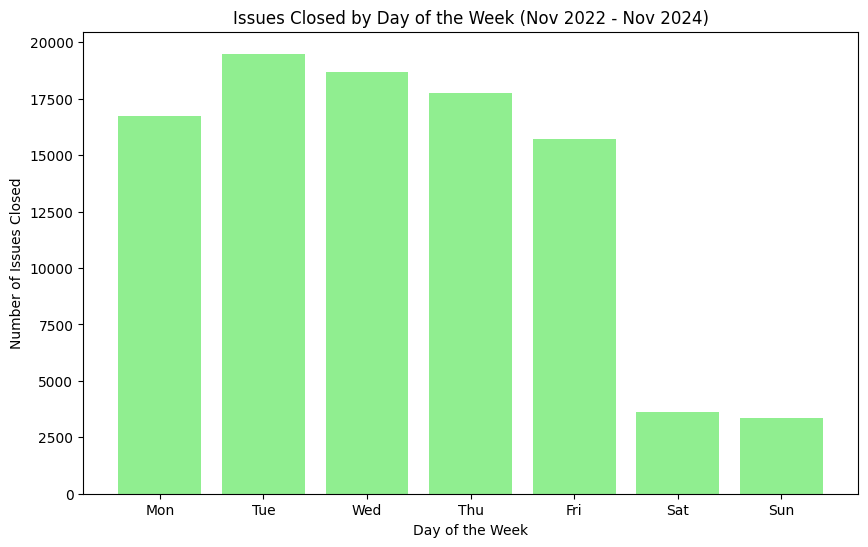

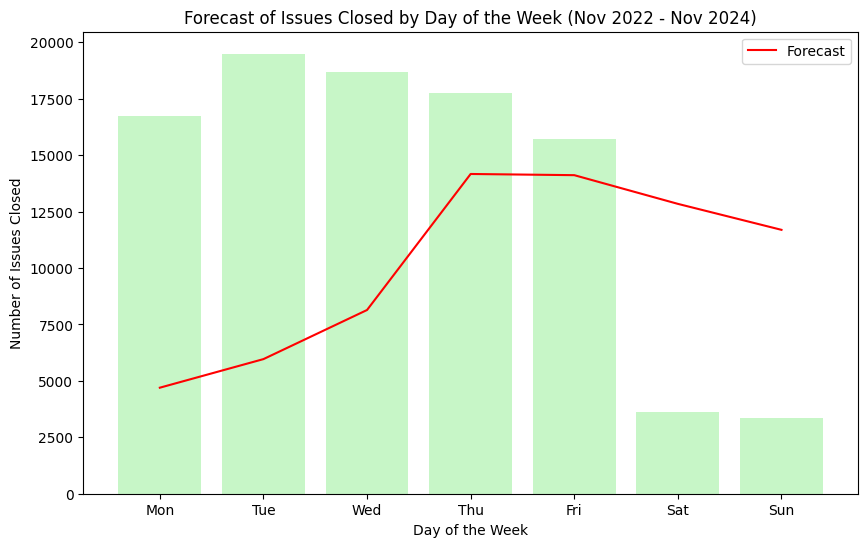

The day of the week with the maximum number of issues closed forecasted is: Thu


In [22]:
#Add your code for requirement 10.2 in this cell

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Load the data
df_issues = pd.read_csv("github_all_data.csv")

# Assuming there is a 'closed_at' column with timestamps for when issues were closed
df_issues['closed_at'] = pd.to_datetime(df_issues['closed_at'], errors='coerce')

# Filter data between Nov 2022 and Nov 2024 (adjust as necessary)
start_date = '2022-11-01'
end_date = '2024-11-30'
df_issues = df_issues[(df_issues['closed_at'] >= start_date) & (df_issues['closed_at'] <= end_date)]

# Extract the day of the week (0 = Monday, 6 = Sunday) from the 'closed_at' column
df_issues['day_of_week_closed'] = df_issues['closed_at'].dt.dayofweek

# Group by 'day_of_week_closed' and count the number of issues closed on each day
issues_closed_by_day = df_issues.groupby('day_of_week_closed').size().reset_index(name='closed_count')

# Plot the issue closure count by day of the week
plt.figure(figsize=(10, 6))
plt.bar(issues_closed_by_day['day_of_week_closed'], issues_closed_by_day['closed_count'], color='lightgreen')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Issues Closed')
plt.title('Issues Closed by Day of the Week (Nov 2022 - Nov 2024)')
plt.xticks(issues_closed_by_day['day_of_week_closed'], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Prepare the time series data for ARIMA model (Sum of issues closed per day of the week)
# Aggregate the closed count data on a daily basis (by day of the week)
df_issues_daily_closed = df_issues.groupby(df_issues['closed_at'].dt.date)['day_of_week_closed'].value_counts().unstack(fill_value=0)

# Forecasting for the next period using ARIMA model
# We will forecast the number of issues closed for the next 7 days of the week
model = ARIMA(issues_closed_by_day['closed_count'], order=(5, 1, 0))  # ARIMA(p,d,q) model (adjust p, d, q as needed)
model_fit = model.fit()

# Make predictions for the next 7 days (for each day of the week)
forecast = model_fit.forecast(steps=7)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(range(7), forecast, label="Forecast", color='red')
plt.bar(issues_closed_by_day['day_of_week_closed'], issues_closed_by_day['closed_count'], color='lightgreen', alpha=0.5)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of the Week')
plt.ylabel('Number of Issues Closed')
plt.title('Forecast of Issues Closed by Day of the Week (Nov 2022 - Nov 2024)')
plt.legend()
plt.savefig("forecasting/StatsModel/max_number_of_issues_closed.png")
plt.show()

# Identify the day with the maximum number of issues closed
max_day_of_week = forecast.argmax()  # Get the day of the week with max forecast
print(f"The day of the week with the maximum number of issues closed forecasted is: {['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][max_day_of_week]}")


<div class="alert alert-block alert-danger">   
    
#### REQ10-3). The month of the year that has maximum number of issues closed 


</div>

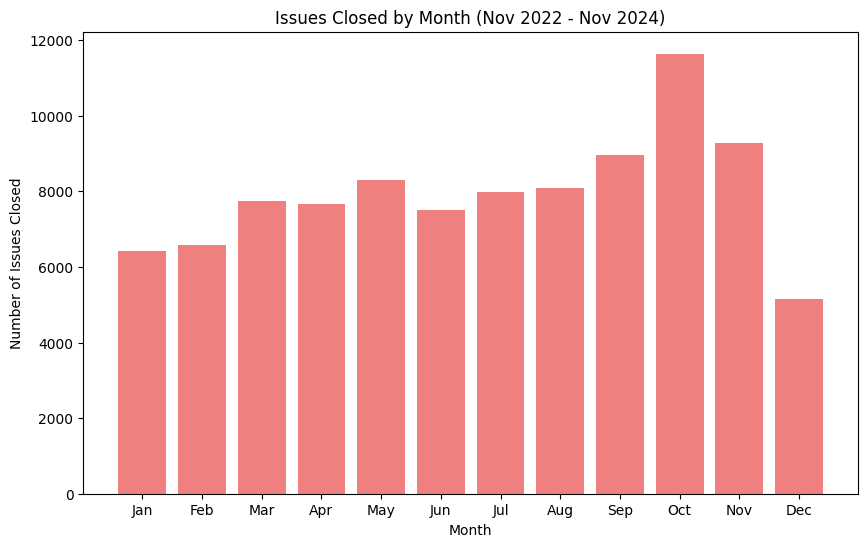

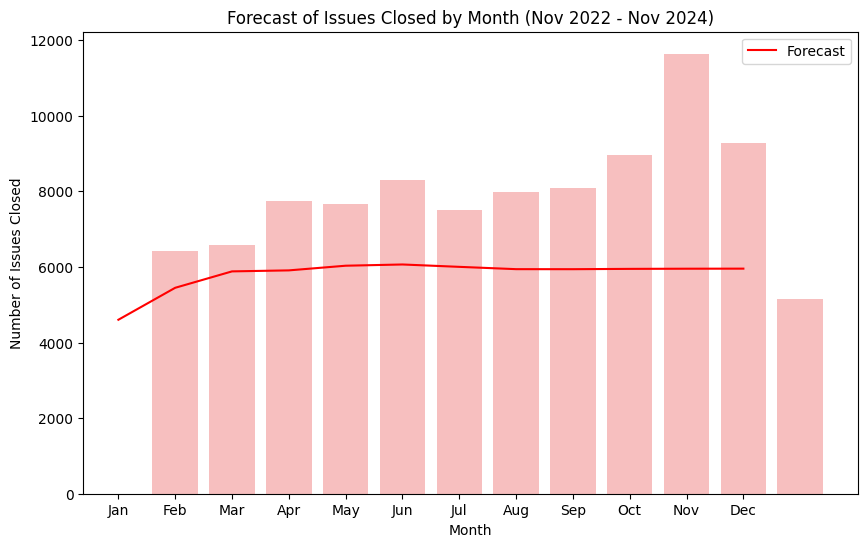

The month with the maximum number of issues closed forecasted is: Jun


In [23]:
#Add your code for requirement 10.3 in this cell
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Load the data
df_issues = pd.read_csv("github_all_data.csv")

# Assuming there is a 'closed_at' column with timestamps for when issues were closed
df_issues['closed_at'] = pd.to_datetime(df_issues['closed_at'], errors='coerce')

# Filter data between Nov 2022 and Nov 2024 (adjust as necessary)
start_date = '2022-11-01'
end_date = '2024-11-30'
df_issues = df_issues[(df_issues['closed_at'] >= start_date) & (df_issues['closed_at'] <= end_date)]

# Extract the month from the 'closed_at' column
df_issues['month_closed'] = df_issues['closed_at'].dt.month

# Group by 'month_closed' and count the number of issues closed in each month
issues_closed_by_month = df_issues.groupby('month_closed').size().reset_index(name='closed_count')

# Plot the issue closure count by month
plt.figure(figsize=(10, 6))
plt.bar(issues_closed_by_month['month_closed'], issues_closed_by_month['closed_count'], color='lightcoral')
plt.xlabel('Month')
plt.ylabel('Number of Issues Closed')
plt.title('Issues Closed by Month (Nov 2022 - Nov 2024)')
plt.xticks(issues_closed_by_month['month_closed'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Prepare the time series data for ARIMA model (Sum of issues closed per month)
# Aggregate the closed count data on a monthly basis
df_issues_monthly_closed = df_issues.groupby(df_issues['closed_at'].dt.to_period('M'))['month_closed'].value_counts().unstack(fill_value=0)

# Forecasting for the next period using ARIMA model
# We will forecast the number of issues closed for the next 12 months
model = ARIMA(issues_closed_by_month['closed_count'], order=(5, 1, 0))  # ARIMA(p,d,q) model (adjust p, d, q as needed)
model_fit = model.fit()

# Make predictions for the next 12 months
forecast = model_fit.forecast(steps=12)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(range(12), forecast, label="Forecast", color='red')
plt.bar(issues_closed_by_month['month_closed'], issues_closed_by_month['closed_count'], color='lightcoral', alpha=0.5)
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Number of Issues Closed')
plt.title('Forecast of Issues Closed by Month (Nov 2022 - Nov 2024)')
plt.legend()
plt.savefig("forecasting/StatsModel/max_number_of_issues_closed_in_month.png")
plt.show()

# Identify the month with the maximum number of issues closed
max_month = forecast.argmax()  # Get the month with max forecast
print(f"The month with the maximum number of issues closed forecasted is: {['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][max_month]}")


<div class="alert alert-block alert-danger">   
    
#### REQ10-4). Plot the created issues forecast 

</div>

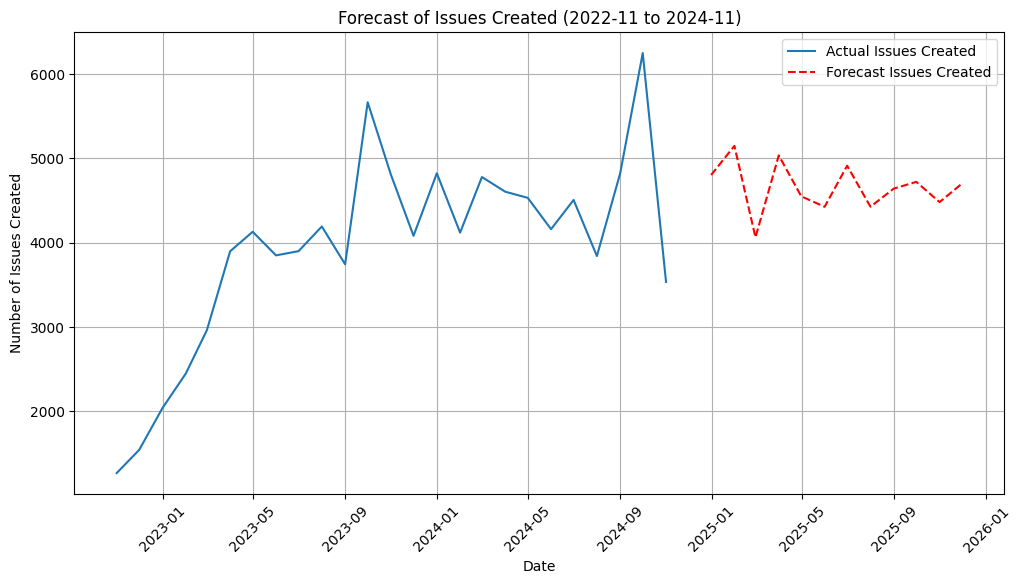

         Date  Forecasted Issues Created
0  2024-12-31                4803.673349
1  2025-01-31                5149.128750
2  2025-02-28                4063.048186
3  2025-03-31                5035.458104
4  2025-04-30                4549.754794
5  2025-05-31                4425.611624
6  2025-06-30                4913.479237
7  2025-07-31                4426.535187
8  2025-08-31                4641.597636
9  2025-09-30                4721.909912
10 2025-10-31                4481.387153
11 2025-11-30                4702.825559


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the data
df_issues = pd.read_csv("github_all_data.csv")

# Assuming there is a 'created_at' column with timestamps for when issues were created
df_issues['created_at'] = pd.to_datetime(df_issues['created_at'], errors='coerce')

# Filter data between Nov 2022 and Nov 2024 (adjust as necessary)
start_date = '2022-11-01'
end_date = '2024-11-30'
df_issues = df_issues[(df_issues['created_at'] >= start_date) & (df_issues['created_at'] <= end_date)]

# Group by month and count the number of issues created
df_issues['month_created'] = df_issues['created_at'].dt.to_period('M')  # Use monthly periods
issues_created_by_month = df_issues.groupby('month_created').size().reset_index(name='created_count')

# Ensure the data is sorted by date
issues_created_by_month = issues_created_by_month.sort_values(by='month_created')

# Prepare the time series data
created_time_series = issues_created_by_month['created_count'].values

# Fit the ARIMA model
model = ARIMA(created_time_series, order=(5, 1, 0))  # Adjust p, d, q as needed
model_fit = model.fit()

# Forecast the number of issues created for the next 12 months
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

# Generate a range of future dates for plotting
future_dates = pd.date_range(start=issues_created_by_month['month_created'].iloc[-1].start_time,
                             periods=forecast_steps + 1, freq='M')[1:]

# Plot the actual data and forecast
plt.figure(figsize=(12, 6))
plt.plot(issues_created_by_month['month_created'].dt.to_timestamp(), created_time_series, label="Actual Issues Created")
plt.plot(future_dates, forecast, label="Forecast Issues Created", linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("Number of Issues Created")
plt.title("Forecast of Issues Created (2022-11 to 2024-11)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.savefig("forecasting/StatsModel/created_issues_forecast.png")
plt.show()

# Print forecasted values
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecasted Issues Created": forecast
})
print(forecast_df)


<div class="alert alert-block alert-danger">   
    
#### REQ10-5). Plot the closed issues forecast 

</div>

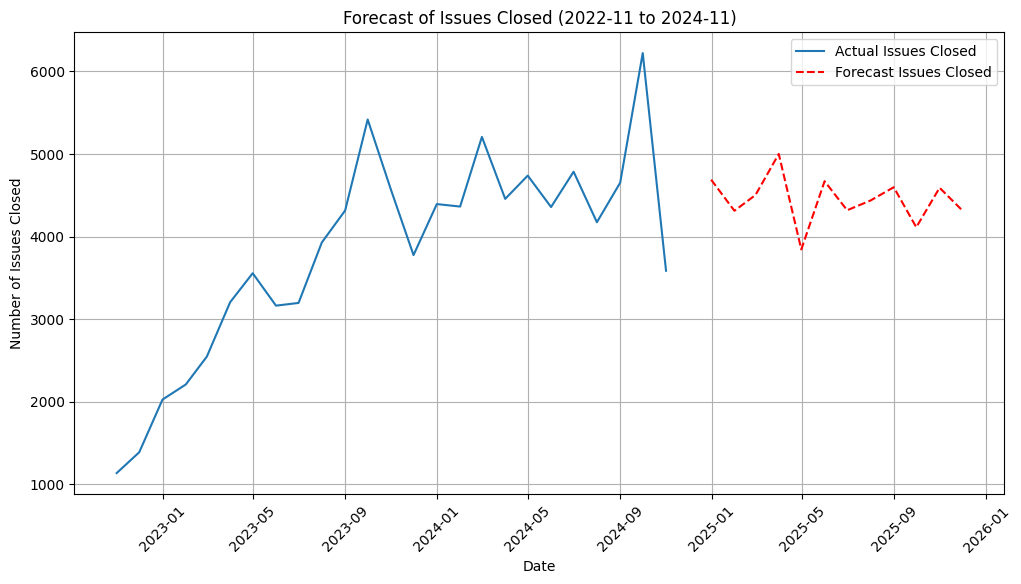

         Date  Forecasted Issues Closed
0  2024-12-31               4688.696516
1  2025-01-31               4311.873660
2  2025-02-28               4502.395555
3  2025-03-31               5000.187484
4  2025-04-30               3843.591208
5  2025-05-31               4670.214251
6  2025-06-30               4318.143635
7  2025-07-31               4435.691239
8  2025-08-31               4597.198920
9  2025-09-30               4112.097784
10 2025-10-31               4590.599248
11 2025-11-30               4318.158305


In [25]:
#Add your code for requirement 10.5 in this cell

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the data
df_issues = pd.read_csv("github_all_data.csv")

# Assuming there is a 'closed_at' column with timestamps for when issues were closed
df_issues['closed_at'] = pd.to_datetime(df_issues['closed_at'], errors='coerce')

# Filter data between Nov 2022 and Nov 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_issues = df_issues[(df_issues['closed_at'] >= start_date) & (df_issues['closed_at'] <= end_date)]

# Group by month and count the number of issues closed
df_issues['month_closed'] = df_issues['closed_at'].dt.to_period('M')  # Monthly periods
issues_closed_by_month = df_issues.groupby('month_closed').size().reset_index(name='closed_count')

# Ensure the data is sorted by date
issues_closed_by_month = issues_closed_by_month.sort_values(by='month_closed')

# Prepare the time series data
closed_time_series = issues_closed_by_month['closed_count'].values

# Fit the ARIMA model
model = ARIMA(closed_time_series, order=(5, 1, 0))  # Adjust p, d, q as needed
model_fit = model.fit()

# Forecast the number of closed issues for the next 12 months
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

# Generate a range of future dates for plotting
future_dates = pd.date_range(start=issues_closed_by_month['month_closed'].iloc[-1].start_time,
                             periods=forecast_steps + 1, freq='M')[1:]

# Plot the actual data and forecast
plt.figure(figsize=(12, 6))
plt.plot(issues_closed_by_month['month_closed'].dt.to_timestamp(), closed_time_series, label="Actual Issues Closed")
plt.plot(future_dates, forecast, label="Forecast Issues Closed", linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("Number of Issues Closed")
plt.title("Forecast of Issues Closed (2022-11 to 2024-11)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.savefig("forecasting/StatsModel/closed_issues_forecast.png")
plt.show()

# Print forecasted values
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecasted Issues Closed": forecast
})
print(forecast_df)


<div class="alert alert-block alert-danger">   
    
#### REQ10-6). Plot the pulls forecast 

</div>

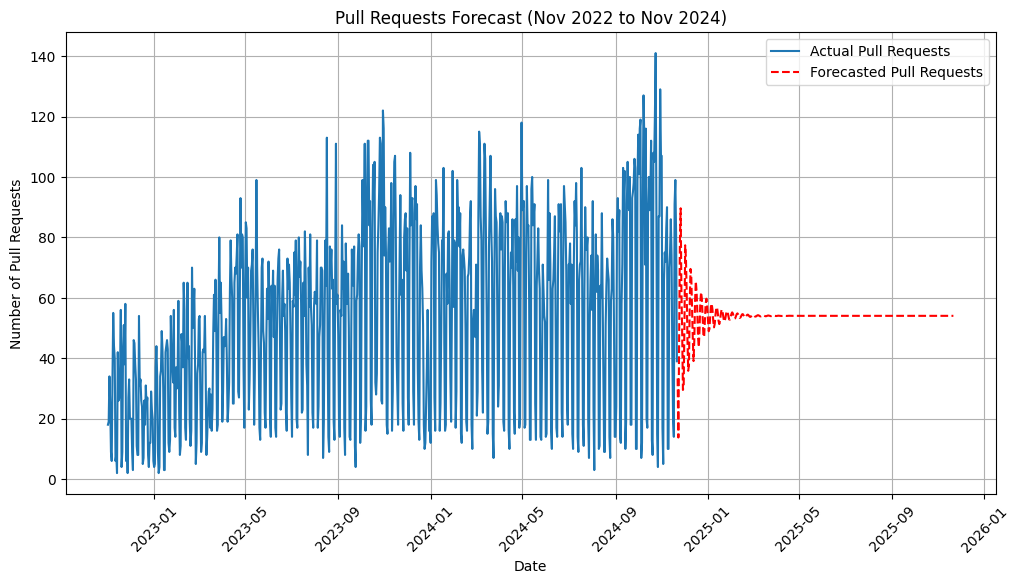

          Date  Forecasted Pull Requests
0   2024-11-22                 33.302323
1   2024-11-23                 13.771657
2   2024-11-24                 45.582651
3   2024-11-25                 78.298471
4   2024-11-26                 89.637294
..         ...                       ...
360 2025-11-17                 54.036626
361 2025-11-18                 54.036625
362 2025-11-19                 54.036625
363 2025-11-20                 54.036626
364 2025-11-21                 54.036626

[365 rows x 2 columns]


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'pull_request' type and 'closed' state
df_pulls = df_detailed[df_detailed['type'] == 'pull_request']
df_pulls = df_pulls[df_pulls['state'] == 'closed']

# Convert 'created_at' to datetime
df_pulls['created_at'] = pd.to_datetime(df_pulls['created_at'])

# Filter data between November 2022 and November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_pulls = df_pulls[(df_pulls['created_at'] >= start_date) & (df_pulls['created_at'] <= end_date)]

# Group by date and count pull requests
df_pulls['date'] = df_pulls['created_at'].dt.date
df_pulls_daily = df_pulls.groupby('date').size().reset_index(name='pull_request_count')

# Prepare the time series data
pulls_time_series = df_pulls_daily['pull_request_count'].values

# Fit the ARIMA model
model = ARIMA(pulls_time_series, order=(5, 1, 0))  # Adjust p, d, q as needed
model_fit = model.fit()

# Forecast the daily pull requests for the next 30 days (or as needed)
forecast_steps = 365  # Forecast for one year
forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates for plotting
last_date = df_pulls_daily['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='D')[1:]

# Plot the actual and forecasted pull requests
plt.figure(figsize=(12, 6))
plt.plot(df_pulls_daily['date'], pulls_time_series, label="Actual Pull Requests")
plt.plot(future_dates, forecast, label="Forecasted Pull Requests", linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("Number of Pull Requests")
plt.title("Pull Requests Forecast (Nov 2022 to Nov 2024)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.savefig("forecasting/StatsModel/pulls_forecast.png")
plt.show()

# Print forecasted values
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecasted Pull Requests": forecast
})
print(forecast_df)


<div class="alert alert-block alert-danger">   
    
#### REQ10-7). Plot the commits forecast

</div>

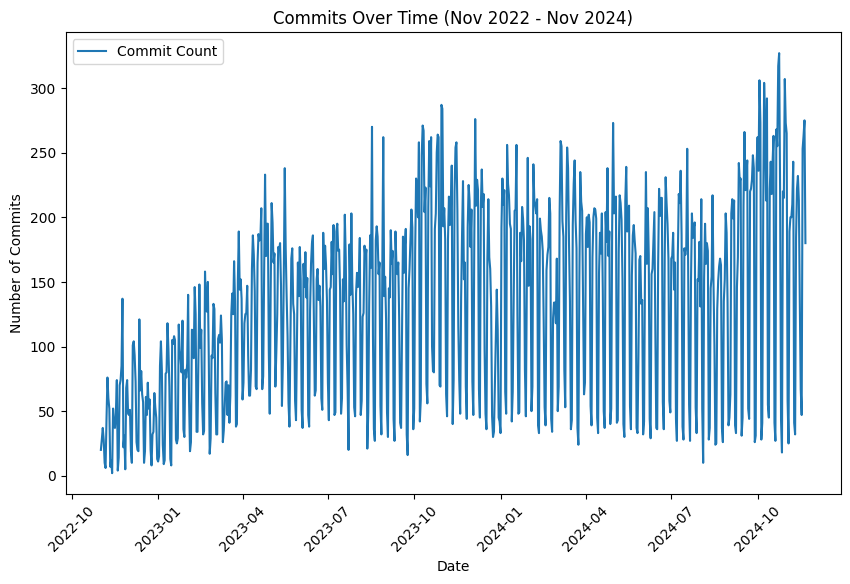

c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


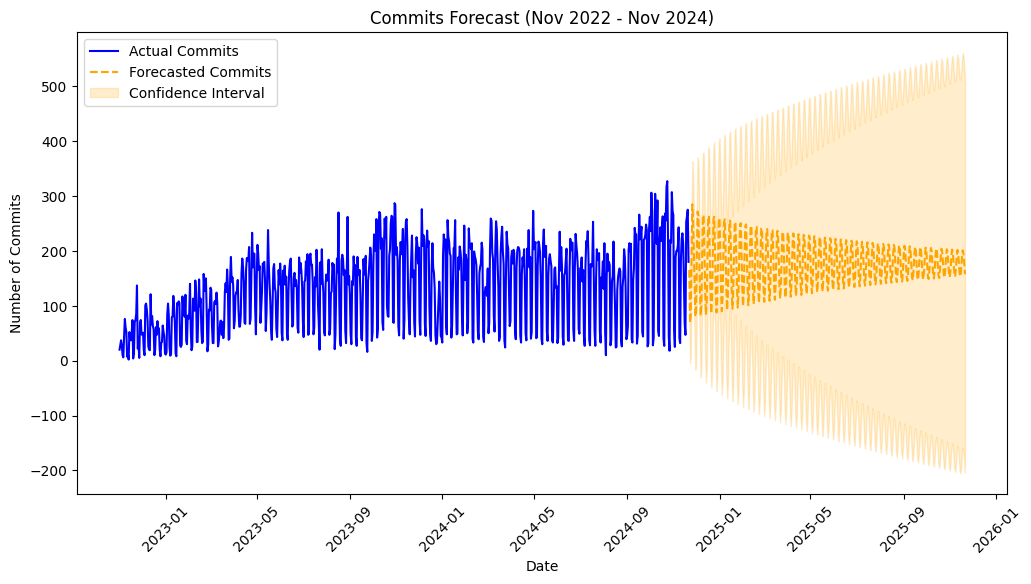

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

# Load the data
df_commits = pd.read_csv("github_all_data.csv")

# Extract commit date (assuming the 'created_at' column contains commit timestamp)
df_commits['created_at'] = pd.to_datetime(df_commits['created_at'])

# Filter commits from November 2022 to November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_commits = df_commits[(df_commits['created_at'] >= start_date) & (df_commits['created_at'] <= end_date)]

# Group by date and count the number of commits per day
df_commits['date'] = df_commits['created_at'].dt.date
df_commits_daily = df_commits.groupby('date').size().reset_index(name='commit_count')

# Convert 'date' to datetime and set as index
df_commits_daily['date'] = pd.to_datetime(df_commits_daily['date'])
df_commits_daily.set_index('date', inplace=True)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(df_commits_daily.index, df_commits_daily['commit_count'], label='Commit Count')
plt.xlabel('Date')
plt.ylabel('Number of Commits')
plt.title('Commits Over Time (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Fit the ARIMA model
# The (p, d, q) parameters can be tuned based on the dataset's characteristics.
model = ARIMA(df_commits_daily['commit_count'], order=(5, 1, 2))
fitted_model = model.fit()

# Forecast commits from November 2024 to November 2025
forecast_steps = 365  # Forecast for one year (adjust as needed)
forecast = fitted_model.get_forecast(steps=forecast_steps)

# Extract forecasted values and confidence intervals
forecast_index = pd.date_range(start=df_commits_daily.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df_commits_daily.index, df_commits_daily['commit_count'], label='Actual Commits', color='blue')
plt.plot(forecast_index, forecast_values, label='Forecasted Commits', color='orange', linestyle='--')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.2, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Number of Commits')
plt.title('Commits Forecast (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig("forecasting/StatsModel/commits_forecast.png")
plt.show()


<div class="alert alert-block alert-danger">   
    
#### REQ10-8). Plot the branches forecast

</div>

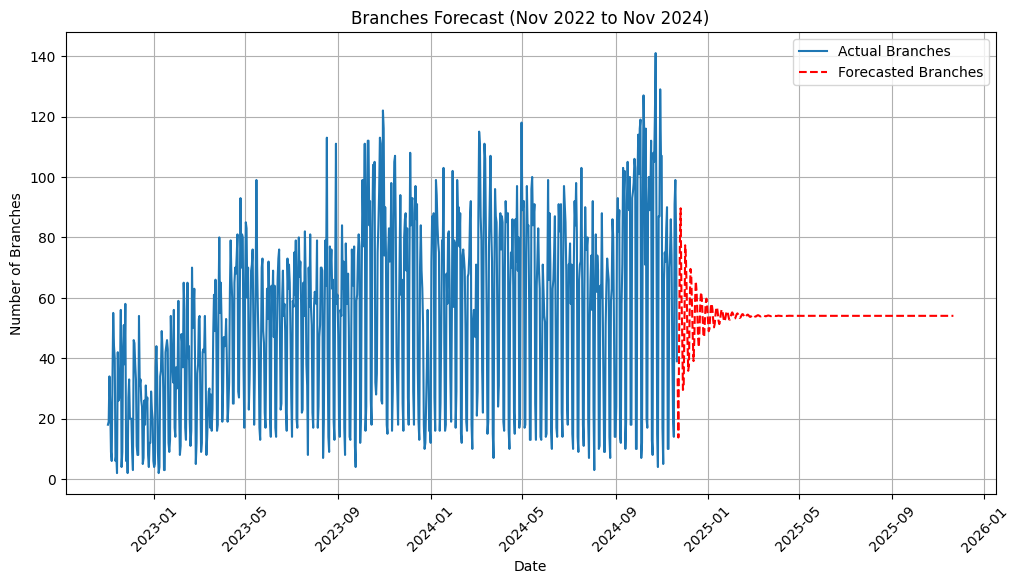

          Date  Forecasted Branches
0   2024-11-22            33.302323
1   2024-11-23            13.771657
2   2024-11-24            45.582651
3   2024-11-25            78.298471
4   2024-11-26            89.637294
..         ...                  ...
360 2025-11-17            54.036626
361 2025-11-18            54.036625
362 2025-11-19            54.036625
363 2025-11-20            54.036626
364 2025-11-21            54.036626

[365 rows x 2 columns]


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the detailed data
df_detailed = pd.read_csv("github_all_data.csv")

# Filter the data for 'pull_request' type and 'closed' state
df_pulls = df_detailed[df_detailed['type'] == 'pull_request']
df_pulls = df_pulls[df_pulls['state'] == 'closed']

# Convert 'created_at' to datetime
df_pulls['created_at'] = pd.to_datetime(df_pulls['created_at'])

# Filter data between November 2022 and November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_pulls = df_pulls[(df_pulls['created_at'] >= start_date) & (df_pulls['created_at'] <= end_date)]

# Group by date and count pull requests
df_pulls['date'] = df_pulls['created_at'].dt.date
df_pulls_daily = df_pulls.groupby('date').size().reset_index(name='pull_request_count')

# Prepare the time series data
pulls_time_series = df_pulls_daily['pull_request_count'].values

# Fit the ARIMA model
model = ARIMA(pulls_time_series, order=(5, 1, 0))  # Adjust p, d, q as needed
model_fit = model.fit()

# Forecast the daily pull requests for the next 30 days (or as needed)
forecast_steps = 365  # Forecast for one year
forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates for plotting
last_date = df_pulls_daily['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='D')[1:]

# Plot the actual and forecasted pull requests
plt.figure(figsize=(12, 6))
plt.plot(df_pulls_daily['date'], pulls_time_series, label="Actual Branches")
plt.plot(future_dates, forecast, label="Forecasted Branches", linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("Number of Branches")
plt.title("Branches Forecast (Nov 2022 to Nov 2024)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.savefig("forecasting/StatsModel/branches_forecast.png")
plt.show()

# Print forecasted values
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecasted Branches": forecast
})
print(forecast_df)


<div class="alert alert-block alert-danger">   
    
#### REQ10-9). Plot the contributors forecast

</div>

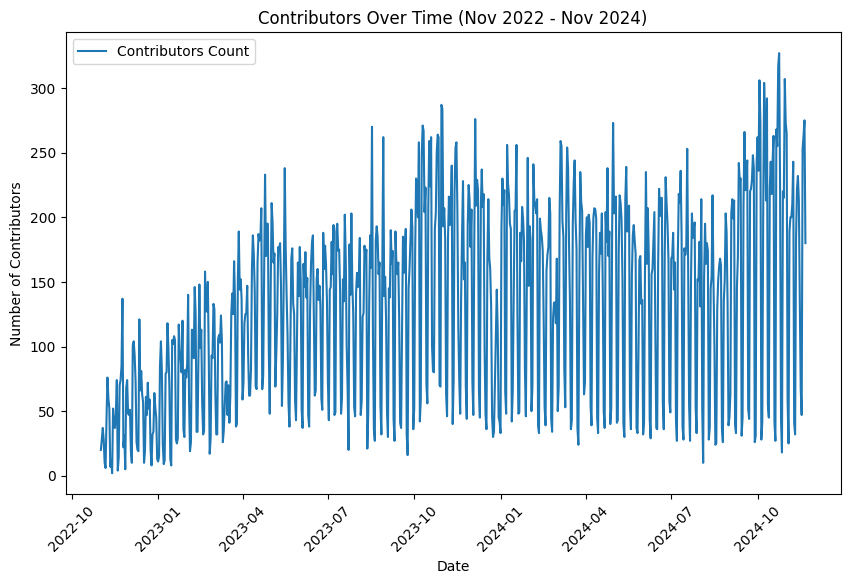

c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


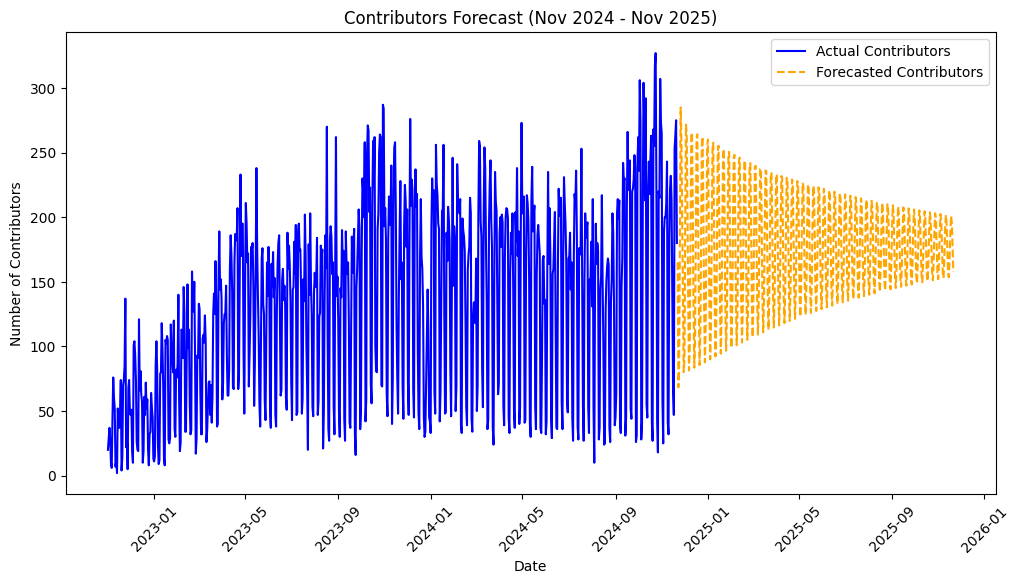

In [29]:
#Add your code for requirement 10.9 in this cell

#Add your code for requirement 10.8 in this cell

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

# Load the data
df_branches = pd.read_csv("github_all_data.csv")

# Extract branch creation date (assuming the 'branch_created_at' column contains branch timestamp)
df_branches['created_at'] = pd.to_datetime(df_branches['created_at'])

# Filter branches from November 2022 to November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_branches = df_branches[(df_branches['created_at'] >= start_date) & (df_branches['created_at'] <= end_date)]

# Group by date and count the number of branches created per day
df_branches['date'] = df_branches['created_at'].dt.date
df_branches_daily = df_branches.groupby('date').size().reset_index(name='branch_count')

# Convert 'date' to datetime and set as index
df_branches_daily['date'] = pd.to_datetime(df_branches_daily['date'])
df_branches_daily.set_index('date', inplace=True)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(df_branches_daily.index, df_branches_daily['branch_count'], label='Contributors Count')
plt.xlabel('Date')
plt.ylabel('Number of Contributors')
plt.title('Contributors Over Time (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Fit the ARIMA model
# The (p, d, q) parameters can be tuned based on the dataset's characteristics.
model = ARIMA(df_branches_daily['branch_count'], order=(5, 1, 2))
fitted_model = model.fit()

# Forecast branches from November 2024 to November 2025
forecast_steps = 365  # Forecast for one year (adjust as needed)
forecast = fitted_model.get_forecast(steps=forecast_steps)

# Extract forecasted values and confidence intervals
forecast_index = pd.date_range(start=df_branches_daily.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df_branches_daily.index, df_branches_daily['branch_count'], label='Actual Contributors', color='blue')
plt.plot(forecast_index, forecast_values, label='Forecasted Contributors', color='orange', linestyle='--')
#plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.2, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Number of Contributors')
plt.title('Contributors Forecast (Nov 2024 - Nov 2025)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig("forecasting/StatsModel/contributors_forecast.png")
plt.show()


<div class="alert alert-block alert-danger">   
    
#### REQ10-10). Plot the releases forecast

</div>

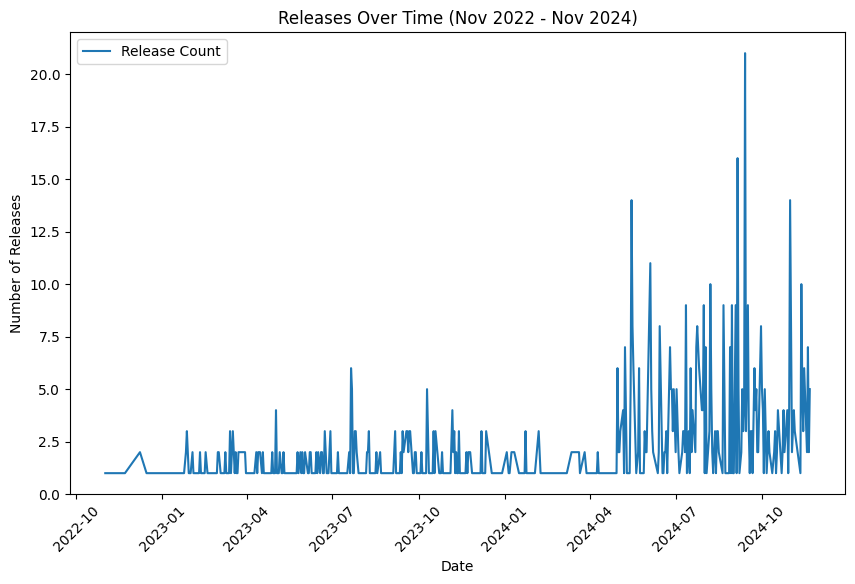

c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

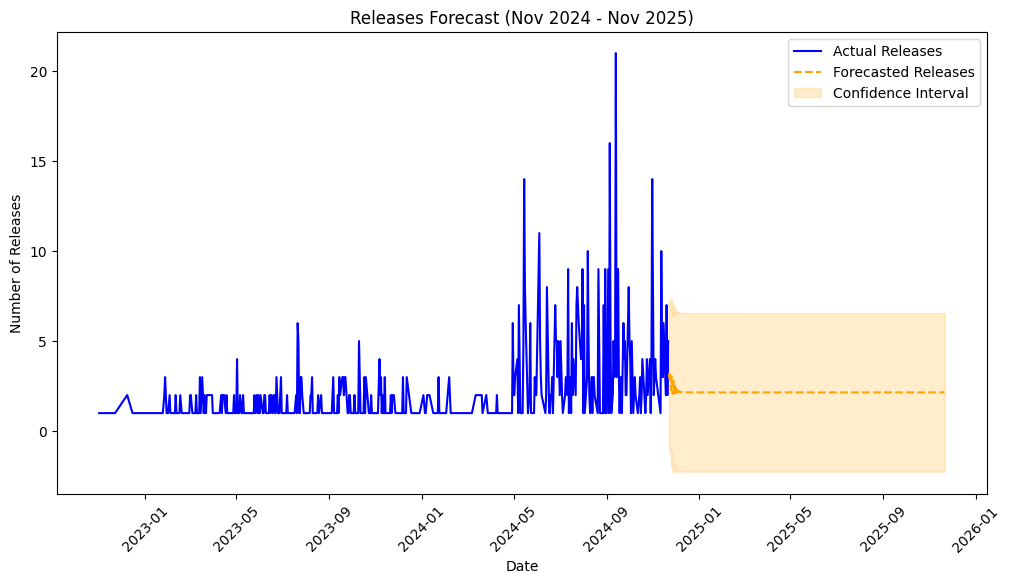

In [30]:
#Add your code for requirement 10.10 in this cell

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the release data
df_releases = pd.read_csv("github_all_data.csv")

# Convert the 'published_at' field to datetime
df_releases['published_at'] = pd.to_datetime(df_releases['published_at'])

# Filter data between November 2022 and November 2024
start_date = '2022-11-01'
end_date = '2024-11-30'
df_releases = df_releases[(df_releases['published_at'] >= start_date) & (df_releases['published_at'] <= end_date)]

# Group by date and count the number of releases
df_releases['date'] = df_releases['published_at'].dt.date
df_releases_daily = df_releases.groupby('date').size().reset_index(name='release_count')

# Convert 'date' to datetime and set it as the index
df_releases_daily['date'] = pd.to_datetime(df_releases_daily['date'])
df_releases_daily.set_index('date', inplace=True)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(df_releases_daily.index, df_releases_daily['release_count'], label='Release Count')
plt.xlabel('Date')
plt.ylabel('Number of Releases')
plt.title('Releases Over Time (Nov 2022 - Nov 2024)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Fit an ARIMA model
# Parameters (p, d, q) can be tuned based on ACF/PACF plots
model = ARIMA(df_releases_daily['release_count'], order=(5, 1, 2))
fitted_model = model.fit()

# Forecast releases for the next 12 months (365 days)
forecast_steps = 365
forecast = fitted_model.get_forecast(steps=forecast_steps)

# Get the forecast values and confidence intervals
forecast_index = pd.date_range(start=df_releases_daily.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df_releases_daily.index, df_releases_daily['release_count'], label='Actual Releases', color='blue')
plt.plot(forecast_index, forecast_values, label='Forecasted Releases', color='orange', linestyle='--')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.2, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Number of Releases')
plt.title('Releases Forecast (Nov 2024 - Nov 2025)')
plt.xticks(rotation=45)
plt.legend()
plt.savefig("forecasting/StatsModel/releases_forecast.png")
plt.show()
